In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymysql
import copy
import seaborn as sns
import fiona
import matplotlib as mpl
import geopandas as gpd
from shapely.geometry import Point,Polygon,shape
from coord_convert.transform import wgs2gcj, wgs2bd, gcj2wgs, gcj2bd, bd2wgs, bd2gcj 
import math
import imp
import plot_map
imp.reload(plot_map)
import esda
from geopandas import GeoDataFrame
import libpysal as lps
from shapely.geometry import Point
import pysal
%matplotlib inline
import time
from scipy.stats import chi2
from matplotlib import patches
import gc

/home/wenbinyao/anaconda3/lib/python3.7/site-packages/libpysal/examples/remotes.py:26: UserWarning: Remote data sets not available. Check connection.
  warnings.warn("Remote data sets not available. Check connection.")
/home/wenbinyao/anaconda3/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [2]:
# 连接mysql数据库
try:
    conn = pymysql.connect(host='localhost', user='', password='', db='', charset='utf8')
    print('数据库连接成功.')
except:
    print('数据库连接失败.')

数据库连接成功.


# 1.第一阶段获得每辆车的出行链

此处出行链指车辆一天被检测器检测的的点位按照时间顺序排序。

In [ ]:
def toSeq(ser):
    # 将每一辆车每一次被检测的信息构成一个list，并存放到dataframe的一个字段里。
    return [ser[2],ser[3],ser[4]]

def merseq(df):
    # 将一辆车所有的被检测信息均合并到一个list中，该list是一个二维数组，每一个元素是一个list，记录该车辆的时空出行链。
#     print(df)
#     print("----------------------------------------------------------------------------------------")
    return list(df['seq'])

In [ ]:
# 统计第一阶段各天每辆车每次trip的OD的时空信息
conn.ping(reconnect=True)
cur = conn.cursor()
tablenames = ['20191217','20191218','20191220','20200106','20200110','20191223','20191224','20191225','20191226','20191227']
FirStaOD = dict()  # 用一个字典来存储第一阶段各天的每辆车每次trip的OD的时空信息
for table in tablenames:
    sql = '''
    select carnum1 , carnum2 , time , LNG , LAT from {}aj2 where (type = 2 or type = 52) and (lng is not null and lat is not null and 
    lng > 119 and lng < 121 and lat > 29 and lat < 30)
    '''.format(table)
    cur.execute(sql)
    conn.commit()
    tmptable = cur.fetchall()
    tmptable = pd.DataFrame(tmptable)
    tmptable.rename(columns = {0:'carnum1' , 1:'carnum2' , 2:'time' , 3:'LNG' , 4:'LAT'} , inplace = True)
    tmptable['carnum'] = tmptable['carnum1'] + tmptable['carnum2']
    # 得到车辆每一天的出行链
    tmptable.sort_values(by = ['carnum' , 'time'] , ascending = (True , True) , inplace=True)
    tmptable.reset_index(drop=True,inplace=True)
    tmptable[['time']] = tmptable[['time']].applymap(lambda x : x[11:13])
    tmptable['seq']=tmptable.apply(toSeq , axis=1)
    tmptable = tmptable.groupby(['carnum']).apply(merseq)
    tmptable = pd.DataFrame(tmptable)
    tmptable.reset_index(inplace = True)
    tmptable.rename(columns={0:table},inplace = True)
    FirStaOD[table] = tmptable
    del tmptable
    gc.collect()
    print(table , " has query successfully!")
cur.close()

In [ ]:
FirStaOD['20191227'].head(2)

In [ ]:
# 把第一阶段各天的sequence合并到一张dataframe中去
FirStaTab=FirStaOD['20191217']
tablenames = ['20191218','20191220','20200106','20200110','20191223','20191224','20191225','20191226','20191227']
for table in tablenames:
    tmptable = FirStaOD[table]
    FirStaTab = pd.merge(FirStaTab,tmptable,how='outer',on='carnum')

# 将FirStaOD释放掉
del FirStaOD
gc.collect()

# 把出现天数少于5天的车辆删除，因为我取5天为阈值，support大于等于5方才认为频繁出行模式，因此少于5天的车不可能有频繁出行模式。
# 该步骤主要为了减少计算量和存储量
def judgedel(ser):
    # 判断该行是否需要删除
    if len(ser[ser.isnull()]) > 5:
        return 1
    else:
        return 0

FirStaTab['tag'] = FirStaTab.apply(judgedel , axis = 1)
FirStaTab = FirStaTab[FirStaTab['tag'] == 0]
FirStaTab.drop(columns=['tag'],inplace=True)
FirStaTab.reset_index(drop=True,inplace=True)
FirStaTab.head(2)

# 2.第一阶段frequent sequential activity pattern mining

In [ ]:
'''
本cell是用prefix span algorithm进行frequent sequence activity pattern mining的算法实现，
并且对两个item是否相同的定义做了修改，只要两个item时间绝对值差1以内，空间直线距离在1km以内，则都认为是相同的item。
算法对空间和时间复杂度考虑较少，因为本研究用该算法挖掘出一个人的在一段时间的frequent sequence activity pattern mining，
因此对于每个人来说数据量都极少。
算法已经经过若干测试均是正确的，该算法将sequence长度为1的pattern删除，仅保留长度大于等于2的pattern，
因为频繁模式挖掘过程中对出行链长度过长的出行者做了出行链压缩，此时早高峰出行可能仅保留为一个点A，晚高峰出行仅保留一个点B，
即长度为2可能为{A,B}的形式，这可能是{home->work,work->home}的形式，而长度为1则出行信息过少，直接删除。
'''
# 定义通过经纬度计算直线距离的函数
from math import radians, cos, sin, asin, sqrt
def geodistance(lng1,lat1,lng2,lat2):
    if lng1 == None or lng2 == None or lat1 == None or lat2 == None:
        return 999999
    elif (lng1 < 119 or lng1 > 121) or (lng2 < 119 or lng2 > 121) or (lat1 < 29 or lat1 > 30) or (lat2 < 29 or lat2 > 30):
        return 999999
    lng1 = float(lng1) ; lng2 = float(lng2) ; lat1 = float(lat1) ; lat2 = float(lat2)
    lng1,lat1,lng2,lat2 = map(radians,[lng1,lat1,lng2,lat2])
    dlon = lng2-lng1
    dlat = lat2-lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    distance = 2* asin(sqrt(a))*6371*1000
    distance = round(distance/1000,3)
    return distance

def issame(l1,l2):
    timetag=0 ; spacetag=0
    if (abs(int(l1[0]) - int(l2[0])) <= 1) :
        timetag=1
    if (geodistance(l1[1],l1[2],l2[1],l2[2])<=1) :
        spacetag=1
    if (timetag + spacetag) == 2:
        return True
    else: 
        return False

# def issame(l1,l2):
#     写代码做case时的判断item是否相同的函数
#     timetag=0 ; spacetag=0
#     if abs(int(l1[0]) - int(l2[0])) <= 1 :
#         timetag=1
#     if abs((l1[1]) - int(l2[1])) <= 1 and abs(int(l1[2]) - int(l2[2])) <= 1:
#         spacetag=1
#     if (timetag + spacetag) == 2:
#         return True
#     else: 
#         return False

def calsup(D ,i,j):
    sup=1  # 初始化D[i][j]的support
    e = D[i][j]
    postfix = []  # 初始化后缀数据库，建立D[i][j]的后缀数据库
    for indexi in range(len(D)):
        if indexi == i:
            pass
        else:
            for indexj in range(len(D[indexi])):
                if issame(e , D[indexi][indexj]):
                    sup += 1
                    postfix.append((indexi,indexj))
                    break
                else:
                    pass
    return sup,postfix

def calsupkb2(D,i,j,postfix):
    # D[i][j]是需要添加在频繁k-1项集后面的元素
    # postfix是频繁k-1项的后缀投影库
    sup=1  # 初始化D[i][j]的support
    e = D[i][j]
    postfix2 = []  # 初始化后缀数据库，建立D[i][j]的后缀数据库
    for indexi in range(len(postfix)):
        postindex=postfix[indexi]
        if postindex[1] >= (len(D[postindex[0]])-1):
            pass
        else:
            for indexj in range(postindex[1]+1 , len(D[postindex[0]])):
                if issame(e , D[postindex[0]][indexj]):
                    sup+=1
                    postfix2.append((postindex[0],indexj))
                    break
                else:
                    pass
    
    return sup,postfix2

def rmdup(freqseq):
    # 将得到的频繁项集中重复的以及长度仅为1的元素去除
    # 去除长度为1的pattern
    needdelind = []
    for i in range(len(freqseq)):
        if len(freqseq[i][0:-3]) < 2:
            needdelind.append(i)
    # 将长度小于2的项删除
    for i in range(len(needdelind)):
        del freqseq[needdelind[len(needdelind)-i-1]]
    
    # 重复的pattern仅保留一项
    freqlen = len(freqseq)
    needdelind = []
    for i in range(freqlen):
        for j in range(0,i):
            if freqseq[i][0:-3] == freqseq[j][0:-3]:
                needdelind.append(i)
                break
    for i in range(len(needdelind)):
        del freqseq[needdelind[len(needdelind)-i-1]]
    
    return freqseq

def prefix_main(E , min_sup):
    # E为sequence矩阵，每一行是一个sequence
    # min_sup是最小支持度
    '''
    输入case：
    p1 = [['07',1,1], 
          ['08',3,3],
          ['16',4,4,],
          ['17',4,4,]]
    p2 = [['07',1,1], 
          ['08',3,3],
          ['16',4,4,],
          ['17',4,4,]]
    p3 = [['07',1,1], 
          ['08',3,3],
          ['16',4,4,],
          ['17',4,4,]]

    E=[p1,p2,p3] 
    prefix_main(E , min_sup=3)
    
    E如上图所示，其中真实数据需要将1,1,3,3,4,4等换为对应的经纬度
    输出case：
    [[['07', 1, 1], ['08', 3, 3], ['16', 4, 4], (0, 2), 3, [(1, 2), (2, 2)]],
     [['07', 1, 1], ['08', 3, 3], ['17', 4, 4], (0, 3), 3, [(1, 2), (2, 2)]],
     [['07', 1, 1], ['16', 4, 4], ['17', 4, 4], (0, 3), 3, [(1, 3), (2, 3)]],
     [['08', 3, 3], ['16', 4, 4], ['17', 4, 4], (0, 3), 3, [(1, 3), (2, 3)]],
     [['07', 1, 1],
      ['08', 3, 3],
      ['16', 4, 4],
      ['17', 4, 4],
      (0, 3),
      3,
      [(1, 3), (2, 3)]]]
    输出是一个list，list中每个元素代表一个pattern，如
    [['07', 1, 1], ['08', 3, 3], ['16', 4, 4], (0, 2), 3, [(1, 2), (2, 2)]]就是一种pattern，
    其中['07', 1, 1], ['08', 3, 3], ['16', 4, 4]代表该pattern的详细信息，
      (0,2)代表该pattern的最后一个item即['16', 4, 4]位于输入的（0,2）位置即E[0][2]；
      3代表该pattern的support为3；
      [(1, 2), (2, 2)]]代表除了自身外，support的另外两个贡献的最后一个sequence在输入中的位置，
      即后缀投影数据库最后一个元素在输入中的位置。
    '''
    
    freqresult=[] # 存储最终的频繁1项集，频繁2项集，频繁3项集···
    freqk_1 = [] # 存储频繁k-1项集
    # 生成初始的频繁1项集
    for i in range(len(E)):
        for j in range(len(E[i])):
            sup , postfix = calsup(E,i,j)  # 计算E[i][j]的support
            if sup >= min_sup:
                freqk_1.append([E[i][j],(i,j),sup,postfix])  # 如果是频繁项集，就以[项,支持度,(该频繁项的最后一个元素所在下标)]的形式添加到freqk中去
    freqresult.extend(freqk_1)
#     print(len(freqresult))
    # 生成频繁k项集
    k=2  # 已获得频繁k-1项集
    while True:
#         print("已经生成频繁{0}项集".format(k))
        freqk = []  #存放频繁k项集
        for indexi in range(len(freqk_1)):
            stmp = freqk_1[indexi]
            if stmp[-3][1] >= (len(E[stmp[-3][0]])-1) :
                pass
            else:
                for indexm in range(stmp[-3][1]+1 , len(E[stmp[-3][0]])):
    #                 stmp2 = E[stmp[-3][0]][indexm]  # 得到想要添加在频繁k-1项集后的元素
                    sup , postfix = calsupkb2(E,stmp[-3][0],indexm,stmp[-1])
                    if sup >= min_sup:
                        freqk.append(stmp[0:-3] + [E[stmp[-3][0]][indexm],(stmp[-3][0],indexm),sup,postfix])
#         print('频繁k项集个数为：',len(freqk))
        if len(freqk) == 0:
            break
        else:
            freqresult.extend(freqk)
            freqk_1 = copy.deepcopy(freqk)
            k+=1
    freqresult = rmdup(freqresult)
    return freqresult

频繁模式挖掘算法复杂度过高，运行了5个小时，连一万行都没有处理完，因此删除掉无用数据，在进行频繁模式的挖掘。

进一步分析了运行速度这么慢的原因，主要是因为prefix_main函数的复杂度会随着出行链的长度出现阶层级上升的情况，因此如果有很长的出行链，如超过20个点位，则7项集的频繁模式就可能需要遍历几十万次。这边用一个实例做一个说明，假设有一个出行者，第一阶段5天都有出行，且每天的出行链均相同，长度为20，则一项集模式有100个，二项集模式有$C_{20}^2*5=950$个，三项集模式有$C_{20}^3*5=5700$个，四项集模式为$C_{20}^4*5=24225$个，依次类推，可以知道7项集有387600个，而且随着出行链长度增长，数量级上升很快，这使得出行链长度长，并且出行者出行规律时无法得到结果，实际过程中，一个出行链长度为25的车辆，5天均出行，出行行为很规律，运行了10个小时没有给出结果。因此针对此问题，需要对出行者的出行链进行压缩，以使得该算法可以在指定时间得到结果。

出行链压缩算法方法如下：出行者一天的行程一小时仅保留support最大的那个点位，即一小时仅保留一个点位信息，如此一来一个出行者一天出行链最长仅24个点位。代码编写思路为：首先，遍历第一天的出行链，若相邻两个点位是处于同一个小时被检测到的，则保留两个点位中support大的那个，删除support小的那个点位。

并不是对所有出行者都做出行链压缩，只有当出行者的出行链过长时才做出行链压缩，具体来说，当出行者至少有min_sup天出行链长度大于等于10时，才做出行链压缩，因此出行者出行链最长也仅仅为9，此时可以控制prefix span的遍历次数最多时为$C_{9}^4*5=630$次，可以接受。

In [ ]:
def rmdata(ser , min_sup=5):
    # 对数据进行预处理及压缩，包括：
    # 1.一周出行少于3天的车辆标记为0，后续直接删除；
    # 2.一周出行大于等于3天的车辆需要进行压缩，出行者一天的行程一小时仅保留support最大的那个点位，即一小时仅保留一个点位信息，
    # 如此一来一个出行者一天出行链最长仅24个点位。
    # 3.但是对于一些出行行为类似于出租车的车辆，经过压缩处理后，可能依然5天均有出行，且出行链长度大于16，
    # 这类车辆会造成prefix span算法爆炸，对于这类车辆，采取手段为保留前5个点位和最后4个点位，舍弃中间点位，因为首末点位对车辆出行行为刻画更为有意义。
#     if ser.name%10000 == 0:
#         print("已经处理到第{0}行.".format(ser.name))
#     ser = ser.dropna()
#     ser = list(ser)
#     ser = ser[1:]
    if len(ser) < min_sup:
        return 0   # 0标签的含义是删除掉这个出行者
    else:
        for i in range(len(ser)):
            j=0
            while j < len(ser[i]):
                sup , _ = calsup(ser ,i,j)
                if sup < min_sup:
                    del ser[i][j]
                else:
                    if j == 0 :
                        j+=1
                    else:
                        if ser[i][j][0] != ser[i][j-1][0]:  # 如果后一个点和前一个点不在同一个小时，则遍历后一个元素；
                            j+=1
                        else:
                            sup , _ = calsup(ser ,i,j) ; sup_1,_=calsup(ser ,i,j-1)
                            if sup <= sup_1:  # 相邻元素中删除掉sup较小的那一个
                                del ser[i][j]
                            else:
                                del ser[i][j-1]
        
        tag1=0 # 标记有多少天的出行链长度大于等于10
        tag2=0 # 标记有多少天的出行链长度大于等于2
        for i in range(len(ser)):
            if len(ser[i]) >= 10:
                tag1 += 1
            if len(ser[i])>=2:
                tag2+=1
        if tag1>=min_sup:
            # 对于长度大于等于10的出行链，仅保留前5个点和最后4个点
            for i in range(len(ser)):
                if len(ser[i]) >= 10:
                    while len(ser[i]) >= 10:
                        del ser[i][5]
        if tag2 < min_sup:
            return 0
        
        return 1  # 1标签意味着保留该出行者

In [ ]:
def getfreqpattern(ser,min_sup=5):
    # 对每一行使用这个func时会直接改变原始dataframe中每一行的元素，因为在本研究中dataframe中存储的是list的引用，因此虽然
    # 深拷贝了dataframe，dataframe中的元素依然是list的引用，对list里的元素处理时依然处理的是原始的list中的数据，
    # 因此会直接改变原始dataframe中list中的元素,详细原因见我的博客：https://blog.csdn.net/qq_39805362/article/details/113060958.
#     ser = ser_copy.copy(deep=True)
    # 得到traveler的frequent pattern
    if ser.name%5000 == 0:
        time_end = time.time()
        consumedtime = time_end - time_begin
        print("已经处理到第{0}行,共耗时{1}分钟.".format(ser.name , round(consumedtime/60 , 3)))

#     time_end = time.time()
#     consumedtime = time_end - time_begin
#     print("已经处理到第{0}行,共耗时{1}分钟.".format(ser.name , round(consumedtime/60 , 3)))
    
    ser = ser.dropna()
    ser = list(ser)
    ser = ser[1:]
    if len(ser) < min_sup:
        return []
    
    tag1=0 # 标记有多少天的出行链长度大于等于10
    tag2=0 # 标记有多少天的出行链长度大于等于2
    totlen = 0 # 记录该阶段被检测总次数
    for i in range(len(ser)):
        totlen = totlen + len(ser[i])
        if len(ser[i]) >= 10:
            tag1 += 1
        if len(ser[i])>=2:
            tag2+=1
    if tag1>=min_sup:
        # 如果有大于min_sup天出行链长度大于等于10，则对出行链进行压缩
        tmp = rmdata(ser , min_sup=min_sup)
        if tmp == 0:
            return []
    elif totlen >= 10 * len(ser):
        # 虽然少于min_sup天出行链长度大于等于10，但是有可能出现某一天出行链长度特别长，如20，而其他天出行链长度均只有9的情况出现
        # 在这种情况下，依然会出现阶层级爆炸的情况，因此也需要做出行链压缩.
        tmp = rmdata(ser , min_sup=min_sup)
        if tmp == 0:
            return []
    if tag2 < min_sup:
        return []
    
    # 注释部分的作用是：如果先保存前面跑出的每个人一周的出行链数据到本地，则dataframe中存储的list格式的元素会变成字符串格式，
    # 此时，直接运行会出bug，因此便需要利用下面的注释部分重新将dataframe中存储的字符串格式的list转化为真正的list格式数据。
#     multidaytrip=[]  # 存储一个人多日的trip chain
#     for i in range(len(ser)):
#         tmp = ser[i].split(',')
#         tripchain = []  # 存储某个人一天的trip chain，形式是二维list的形式
#         index = 0
#         while index <= len(tmp) - 1:
#             if index % 6 == 0:
#                 tmp_list=[]  # 存储某一个人一次trip的OD信息
#                 ele = tmp[index]
#                 tmp_list.append(ele[3:-1])
#             elif index%6==1 or index%6==2 or  index%6==4:
#                 tmp_list.append(float(tmp[index]))
#             elif index%6==3:
#                 tmp_list.append(tmp[index][2:-1])
#             elif index%6==5:
#                 ele = tmp[index]
#                 tmp_list.append(float(ele[0:-2]))
#                 tripchain.append(tmp_list)
#             index += 1
# #         print(tripchain)
#         multidaytrip.append(tripchain)

    freqseq = prefix_main(ser , min_sup)
    return freqseq

In [ ]:
# 验证代码的正确性
# 用自己的一个case测试一下代码正确性
time_begin = time.time()
case = copy.deepcopy(FirStaTab.iloc[0:3,:])
case.loc[3] = ['我增加的一行',
           [['18', 119.928, 29.2736], ['19', 119.92, 29.2649], ['21', 119.928, 29.2732]],
           [['18', 119.928, 29.2736], ['19', 119.92, 29.2649], ['21', 119.928, 29.2732]],
           [['18', 119.928, 29.2736], ['19', 119.92, 29.2649], ['21', 119.928, 29.2732]],
           [['18', 119.928, 29.2736], ['19', 119.92, 29.2649], ['21', 119.928, 29.2732]],
           [['18', 119.928, 29.2736], ['19', 119.92, 29.2649], ['21', 119.928, 29.2732]],
            None,None,None,None,None]
res = case.apply(getfreqpattern,axis=1)
res

In [ ]:
res[3]

In [ ]:
# 再来一个出行链超长的出行者做一个case
# 检验上面cell写的数据压缩算法的正确性
case = FirStaTab.iloc[0:3 , :]
case.loc[3]=['我增加的一行',
           [['01', 119.928, 29.2736],['02', 119.928, 29.2736],['03', 119.928, 29.2736],['04', 119.928, 29.2736],['05', 119.928, 29.2736],['06', 119.928, 29.2736],['07', 119.928, 29.2736],['08', 119.928, 29.2736],['09', 119.928, 29.2736],['10', 119.928, 29.2736],['11', 119.928, 29.2736],['12', 119.928, 29.2736],['13', 119.928, 29.2736],['14', 119.928, 29.2736],['15', 119.928, 29.2736],['16', 119.928, 29.2736],['17', 119.928, 29.2736],['18', 119.928, 29.2736], ['19', 119.92, 29.2649], ['19', 10.92, 29.2649], ['19', 119.92, 29.2649], ['19', 119.92, 29.2649], ['21', 119.928, 29.2732]],
           [['01', 119.928, 29.2736],['02', 119.928, 29.2736],['03', 119.928, 29.2736],['04', 119.928, 29.2736],['05', 119.928, 29.2736],['06', 119.928, 29.2736],['07', 119.928, 29.2736],['08', 119.928, 29.2736],['09', 119.928, 29.2736],['10', 119.928, 29.2736],['11', 119.928, 29.2736],['12', 119.928, 29.2736],['13', 119.928, 29.2736],['14', 119.928, 29.2736],['15', 119.928, 29.2736],['16', 119.928, 29.2736],['17', 119.928, 29.2736],['18', 119.928, 29.2736], ['19', 119.92, 29.2649], ['19', 10.92, 29.2649], ['19', 119.92, 29.2649], ['19', 119.92, 29.2649], ['21', 119.928, 29.2732]],
           [['01', 119.928, 29.2736],['02', 119.928, 29.2736],['03', 119.928, 29.2736],['04', 119.928, 29.2736],['05', 119.928, 29.2736],['06', 119.928, 29.2736],['07', 119.928, 29.2736],['08', 119.928, 29.2736],['09', 119.928, 29.2736],['10', 119.928, 29.2736],['11', 119.928, 29.2736],['12', 119.928, 29.2736],['13', 119.928, 29.2736],['14', 119.928, 29.2736],['15', 119.928, 29.2736],['16', 119.928, 29.2736],['17', 119.928, 29.2736],['18', 119.928, 29.2736], ['19', 119.92, 29.2649], ['19', 10.92, 29.2649], ['19', 119.92, 29.2649], ['19', 119.92, 29.2649], ['21', 119.928, 29.2732]],
           [['01', 119.928, 29.2736],['02', 119.928, 29.2736],['03', 119.928, 29.2736],['04', 119.928, 29.2736],['05', 119.928, 29.2736],['06', 119.928, 29.2736],['07', 119.928, 29.2736],['08', 119.928, 29.2736],['09', 119.928, 29.2736],['10', 119.928, 29.2736],['11', 119.928, 29.2736],['12', 119.928, 29.2736],['13', 119.928, 29.2736],['14', 119.928, 29.2736],['15', 119.928, 29.2736],['16', 119.928, 29.2736],['17', 119.928, 29.2736],['18', 119.928, 29.2736], ['19', 119.92, 29.2649], ['19', 10.92, 29.2649], ['19', 119.92, 29.2649], ['19', 119.92, 29.2649], ['21', 119.928, 29.2732]],
           [['01', 119.928, 29.2736],['02', 119.928, 29.2736],['03', 119.928, 29.2736],['04', 119.928, 29.2736],['05', 119.928, 29.2736],['06', 119.928, 29.2736],['07', 119.928, 29.2736],['08', 119.928, 29.2736],['09', 119.928, 29.2736],['10', 119.928, 29.2736],['11', 119.928, 29.2736],['12', 119.928, 29.2736],['13', 119.928, 29.2736],['14', 119.928, 29.2736],['15', 119.928, 29.2736],['16', 119.928, 29.2736],['17', 119.928, 29.2736],['18', 119.928, 29.2736], ['19', 119.92, 29.2649], ['19', 10.92, 29.2649], ['19', 119.92, 29.2649], ['19', 119.92, 29.2649], ['21', 119.928, 29.2732]],
            None,None,None,None,None]
res = case.apply(getfreqpattern,axis=1)
res

In [ ]:
res[3][-1]

In [ ]:
time_begin = time.time()
FirStaTab['freseq'] = FirStaTab.apply(getfreqpattern,axis=1)
FirStaTab.head(2)

In [ ]:
# 将得不到frequent sequence activity pattern 的人都去除掉
def keepornot(x):
    if len(x) == 0:
        return None
    else:
        return x
FirStaTab['freseq'] = FirStaTab[['freseq']].applymap(keepornot)
FirStaTab = FirStaTab[FirStaTab['freseq'].notnull()]
FirStaTab.head(5)

# 3 第一阶段阶段内regularity计算

In [ ]:
def getLCS(s1,s2):
    # 获得最长s1，s2最长公共子串的长度
    len1 = len(s1) ; len2 = len(s2)
    if len1 >= len2:
        lcs = []  # 存储最长公共子串
        startindex = 0  # s2中开始检索有无该item的下标起始位置
        for i in range(len1):
            tmp = s1[i]
            # 去s2中找有没有tmp
            for j in range(startindex , len2):
                if issame(s2[j],tmp):
                    lcs.append(tmp)
                    startindex = j+1
                    break
        return len(lcs)
    else:
        lcs = []  # 存储最长公共子串
        startindex = 0
        for i in range(len2):
            tmp=s2[i]
            for j in range(startindex,len1):
                if issame(s1[j],tmp):
                    lcs.append(tmp)
                    startindex = j+1
                    break
        return len(lcs)
   
# test case
getLCS([['07', 120.086, 29.3184], ['19', 120.058, 29.3415]] ,
       [['06', 120.091, 29.3107], ['19', 130.058, 29.3415]] )  

In [ ]:
def pattern_simi(p1,p2):
    # 计算pattern1和pattern2的similarity
    lenp1 = len(p1)
    lenp2 = len(p2)
    lenLCS = getLCS(p1,p2)
    patsimi = (lenLCS+lenLCS) / (lenp1 + lenp2)
    return patsimi

In [ ]:
def intraweight(ser):
    # 计算阶段内的intra person regularity
    ser = ser.dropna() # 删除空值
    ser = list(ser)
    ser = ser[1:-1]
    weig = 0
    total_simi = 0
    for i in range(len(ser)):
        for j in range(len(ser)):
            if len(ser[i]) != 0 and len(ser[j])!=0:
                tmp = pattern_simi(ser[i],ser[j])
                total_simi = total_simi+tmp
                weig += 1
    return (total_simi / weig)

# a test case
# sercase = FirStaTab.iloc[3,:]
# print(sercase)
# intraweight(sercase)

**第一阶段内出行者regularity计算，并存为regu字段**

In [ ]:
FirStaTab['regu'] = FirStaTab.apply(intraweight , axis = 1)
FirStaTab.head(3)

In [ ]:
FirStaTab = FirStaTab[['carnum','freseq','regu']]
FirStaTab.head(2)

In [ ]:
FirStaTab.to_csv('FirStaTab.csv',encoding = 'gbk',index=False)

In [ ]:
len(FirStaTab)

# 4.第二阶段trip挖掘,frequent sequence pattern mining,regularity,similarity计算

In [ ]:
# 统计第二阶段各天每辆车每次trip的OD的时空信息
conn.ping(reconnect=True)
cur = conn.cursor()
tablenames = ['20200210','20200211','20200212','20200213','20200214','20200217','20200218','20200219','20200220','20200221']
SecStaOD = dict()  # 用一个字典来存储第二阶段各天的每辆车每次trip的OD的时空信息
for table in tablenames:
    sql = '''
    select carnum1 , carnum2 , time , LNG , LAT from {}aj2 where (type = 2 or type = 52) and (lng is not null and lat is not null and 
    lng > 119 and lng < 121 and lat > 29 and lat < 30)
    '''.format(table)
    cur.execute(sql)
    conn.commit()
    tmptable = cur.fetchall()
    tmptable = pd.DataFrame(tmptable)
    tmptable.rename(columns = {0:'carnum1' , 1:'carnum2' , 2:'time' , 3:'LNG' , 4:'LAT'} , inplace = True)
    tmptable['carnum'] = tmptable['carnum1'] + tmptable['carnum2']
    # 得到车辆每一天的出行链
    tmptable.sort_values(by = ['carnum' , 'time'] , ascending = (True , True) , inplace=True)
    tmptable.reset_index(drop=True,inplace=True)
    tmptable[['time']] = tmptable[['time']].applymap(lambda x : x[11:13])
    tmptable['seq']=tmptable.apply(toSeq , axis=1)
    tmptable = tmptable.groupby(['carnum']).apply(merseq)
    tmptable = pd.DataFrame(tmptable)
    tmptable.reset_index(inplace = True)
    tmptable.rename(columns={0:table},inplace = True)
    SecStaOD[table] = tmptable
    del tmptable
    gc.collect()
    print(table , " has query successfully!")
cur.close()

In [ ]:
SecStaOD['20200210'].head(3)

In [ ]:
# 把第一阶段各天的sequence合并到一张dataframe中去
SecStaTab=SecStaOD['20200210']
tablenames = ['20200211','20200212','20200213','20200214','20200217','20200218','20200219','20200220','20200221']
for table in tablenames:
    tmptable = SecStaOD[table]
    SecStaTab = pd.merge(SecStaTab,tmptable,how='outer',on='carnum')

# 将FirStaOD释放掉
del SecStaOD
gc.collect()

# 把出现天数少于5天的车辆删除，因为我取5天为阈值，support大于等于5方才认为频繁出行模式，因此少于5天的车不可能有频繁出行模式。
# 该步骤主要为了减少计算量和存储量
def judgedel(ser):
    # 判断该行是否需要删除
    if len(ser[ser.isnull()]) > 5:
        return 1
    else:
        return 0

SecStaTab['tag'] = SecStaTab.apply(judgedel , axis = 1)
SecStaTab = SecStaTab[SecStaTab['tag'] == 0]
SecStaTab.drop(columns=['tag'],inplace=True)
SecStaTab.reset_index(drop=True,inplace=True)
SecStaTab.head(2)

In [ ]:
time_begin = time.time()
SecStaTab['freseq'] = SecStaTab.apply(getfreqpattern,axis=1)
SecStaTab.head(2)

In [ ]:
# 将得不到frequent sequence activity pattern 的人都去除掉
def keepornot(x):
    if len(x) == 0:
        return None
    else:
        return x
SecStaTab['freseq'] = SecStaTab[['freseq']].applymap(keepornot)
SecStaTab = SecStaTab[SecStaTab['freseq'].notnull()]
SecStaTab.head(2)

In [ ]:
# 第二阶段regularity地计算
SecStaTab['regu'] = SecStaTab.apply(intraweight , axis = 1)
SecStaTab.head(3)

In [ ]:
SecStaTab = SecStaTab[['carnum','freseq','regu']]
SecStaTab.head(2)

In [ ]:
SecStaTab.to_csv('SecStaTab.csv',encoding = 'gbk',index=False)
len(SecStaTab)

# 5.第三阶段trip挖掘,frequent sequence pattern mining,regularity,similarity计算（原来的第三阶段不再运行，因为现在总共只需要划分为三个阶段，原第四阶段现在更改为第三阶段）

In [ ]:
# # 统计第三阶段各天每辆车每次trip的OD的时空信息
# conn.ping(reconnect=True)
# cur = conn.cursor()
# sql = '''
#     select carnum1 , carnum2 , concat(carnum1 , carnum2) as carnum from smalocalizedvehicles
#     '''
# cur.execute(sql)
# conn.commit()
# localveh = cur.fetchall()
# localveh = pd.DataFrame(localveh)
# localveh.rename(columns = {0:'carnum1' , 1:'carnum2' , 2:'carnum'} , inplace = True)
# tablenames = ['20200316','20200317','20200318','20200319','20200320']
# ThiStaOD = dict()  # 用一个字典来存储第一阶段各天的每辆车每次trip的OD的时空信息
# for table in tablenames:
#     sql = '''
#     select carnum1 , carnum2 , time , LNG , LAT from {}aj where (type = 2 or type = 52) and (lng is not null and lat is not null and 
#     lng > 119 and lng < 121 and lat > 29 and lat < 30)
#     '''.format(table)
#     cur.execute(sql)
#     conn.commit()
#     tmptable = cur.fetchall()
#     tmptable = pd.DataFrame(tmptable)
#     tmptable.rename(columns = {0:'carnum1' , 1:'carnum2' , 2:'time' , 3:'LNG' , 4:'LAT'} , inplace = True)
#     tmptable = pd.merge(tmptable , localveh , how = 'inner' , on = ['carnum1' , 'carnum2'])
    
#     # 得到车辆每一天的出行链
#     tmptable.sort_values(by = ['carnum' , 'time'] , ascending = (True , True) , inplace=True)
#     tmptable.reset_index(drop=True,inplace=True)
#     tmptable[['time']] = tmptable[['time']].applymap(lambda x : x[11:13])
#     tmptable['seq']=tmptable.apply(toSeq , axis=1)
#     tmptable = tmptable.groupby(['carnum']).apply(merseq)
#     tmptable = pd.DataFrame(tmptable)
#     tmptable.reset_index(inplace = True)
#     tmptable.rename(columns={0:table},inplace = True)
#     ThiStaOD[table] = tmptable
#     print(table , " has query successfully!")
# cur.close()

In [ ]:
# ThiStaOD['20200316']

In [ ]:
# # 把第一阶段各天的sequence合并到一张dataframe中去
# ThiStaTab=ThiStaOD['20200316']
# tablenames = ['20200317','20200318','20200319','20200320']
# for table in tablenames:
#     tmptable = ThiStaOD[table]
#     ThiStaTab = pd.merge(ThiStaTab,tmptable,how='outer',on='carnum')
# ThiStaTab.head(5)

In [ ]:
# time_begin = time.time()
# ThiStaTab['freseq'] = ThiStaTab.apply(getfreqpattern,axis=1)
# ThiStaTab.head(2)

In [ ]:
# # 将得不到frequent sequence activity pattern 的人都去除掉
# def keepornot(x):
#     if len(x) == 0:
#         return None
#     else:
#         return x
# ThiStaTab['freseq'] = ThiStaTab[['freseq']].applymap(keepornot)
# ThiStaTab = ThiStaTab[ThiStaTab['freseq'].notnull()]
# ThiStaTab.head(5)

In [ ]:
# len(ThiStaTab)

In [ ]:
# # 第三阶段regularity地计算
# ThiStaTab['regu'] = ThiStaTab.apply(intraweight , axis = 1)
# ThiStaTab.head(3)

In [ ]:
# ThiStaTab = ThiStaTab[['carnum','freseq','regu']]
# ThiStaTab.head(2)

In [ ]:
# # 释放第三阶段一些用不到的内存
# import gc
# del ThiStaOD
# gc.collect()

# 6.第三阶段（原第四阶段）trip挖掘,frequent sequence pattern mining,regularity,similarity计算

In [ ]:
# 统计第三（原第四）阶段各天每辆车每次trip的OD的时空信息
conn.ping(reconnect=True)
cur = conn.cursor()
tablenames = ['20200608','20200609','20200610','20200611','20200612','20200615','20200616','20200617','20200618','20200619']
FouStaOD = dict()  # 用一个字典来存储第二阶段各天的每辆车每次trip的OD的时空信息
for table in tablenames:
    sql = '''
    select carnum1 , carnum2 , time , LNG , LAT from {}aj2 where (type = 2 or type = 52) and (lng is not null and lat is not null and 
    lng > 119 and lng < 121 and lat > 29 and lat < 30)
    '''.format(table)
    cur.execute(sql)
    conn.commit()
    tmptable = cur.fetchall()
    tmptable = pd.DataFrame(tmptable)
    tmptable.rename(columns = {0:'carnum1' , 1:'carnum2' , 2:'time' , 3:'LNG' , 4:'LAT'} , inplace = True)
    tmptable['carnum'] = tmptable['carnum1'] + tmptable['carnum2']
    # 得到车辆每一天的出行链
    tmptable.sort_values(by = ['carnum' , 'time'] , ascending = (True , True) , inplace=True)
    tmptable.reset_index(drop=True,inplace=True)
    tmptable[['time']] = tmptable[['time']].applymap(lambda x : x[11:13])
    tmptable['seq']=tmptable.apply(toSeq , axis=1)
    tmptable = tmptable.groupby(['carnum']).apply(merseq)
    tmptable = pd.DataFrame(tmptable)
    tmptable.reset_index(inplace = True)
    tmptable.rename(columns={0:table},inplace = True)
    FouStaOD[table] = tmptable
    del tmptable
    gc.collect()
    print(table , " has query successfully!")
cur.close()

In [ ]:
FouStaOD['20200608'].head(3)

In [ ]:
# 把第四阶段各天的sequence合并到一张dataframe中去
FouStaTab=FouStaOD['20200608']
tablenames = ['20200609','20200610','20200611','20200612','20200615','20200616','20200617','20200618','20200619']
for table in tablenames:
    tmptable = FouStaOD[table]
    FouStaTab = pd.merge(FouStaTab,tmptable,how='outer',on='carnum')

# 将FirStaOD释放掉
del FouStaOD
gc.collect()

# 把出现天数少于5天的车辆删除，因为我取5天为阈值，support大于等于5方才认为频繁出行模式，因此少于5天的车不可能有频繁出行模式。
# 该步骤主要为了减少计算量和存储量
def judgedel(ser):
    # 判断该行是否需要删除
    if len(ser[ser.isnull()]) > 5:
        return 1
    else:
        return 0

FouStaTab['tag'] = FouStaTab.apply(judgedel , axis = 1)
FouStaTab = FouStaTab[FouStaTab['tag'] == 0]
FouStaTab.drop(columns=['tag'],inplace=True)
FouStaTab.reset_index(drop=True,inplace=True)
FouStaTab.head(2)

In [ ]:
time_begin = time.time()
FouStaTab['freseq'] = FouStaTab.apply(getfreqpattern,axis=1)
FouStaTab.head(2)

In [ ]:
# 将得不到frequent sequence activity pattern 的人都去除掉
def keepornot(x):
    if len(x) == 0:
        return None
    else:
        return x
FouStaTab['freseq'] = FouStaTab[['freseq']].applymap(keepornot)
FouStaTab = FouStaTab[FouStaTab['freseq'].notnull()]
FouStaTab.head(2)

In [ ]:
# 第四阶段regularity地计算
FouStaTab['regu'] = FouStaTab.apply(intraweight , axis = 1)
FouStaTab.head(3)

In [ ]:
FouStaTab = FouStaTab[['carnum','freseq','regu']]
FouStaTab.head(2)

In [ ]:
FouStaTab.to_csv('FouStaTab.csv',encoding = 'gbk',index=False)
len(FouStaTab)

# 6.5 各阶段频繁出行模式数据读入及处理

由于数据量过大，每次提取完一阶段的频繁出行模式都需要关闭jupyter并清除内存，这导致内存中的FirStaTab，SecStaTab，FouStaTab都消失了，因此需要重新读入，并将频繁出行模式从字符串重新转换为list格式。

In [ ]:
def str2list(x):
    if type(x) == float:
        return x
    else:
        return eval(x)

In [ ]:
FirStaTab = pd.read_csv("FirStaTab.csv",encoding='gbk')
SecStaTab = pd.read_csv("SecStaTab.csv",encoding='gbk')
FouStaTab = pd.read_csv("FouStaTab.csv",encoding='gbk')
# 频繁出行模式字符串转化为list
FirStaTab['freseq'] = FirStaTab[['freseq']].applymap(str2list)
SecStaTab['freseq'] = SecStaTab[['freseq']].applymap(str2list)
FouStaTab['freseq'] = FouStaTab[['freseq']].applymap(str2list)
type(FirStaTab.iloc[0,:]['freseq'])

# 7.各阶段frequent sequence activity pattern及regularity聚合到一张dataframe中去，并进行阶段间similarity计算，此外，挖掘出各个阶段的被检测频次均值

## 7.1 第一二三（原四）阶段聚合为一张dataframe

In [ ]:
AllStaPat = pd.merge(FirStaTab[['carnum','freseq','regu']],SecStaTab[['carnum','freseq','regu']],on ='carnum' ,how='left')
AllStaPat.rename(columns={'freseq_x':'freseq1','regu_x':'regu1','freseq_y':'freseq2','regu_y':'regu2'},inplace=True)
# AllStaPat = pd.merge(AllStaPat,ThiStaTab[['carnum','freseq','regu']],on ='carnum' ,how='left' )
# AllStaPat.rename(columns={'freseq':'freseq3','regu':'regu3'},inplace = True)
AllStaPat = pd.merge(AllStaPat,FouStaTab[['carnum','freseq','regu']],on ='carnum' ,how='left' )
AllStaPat.rename(columns={'freseq':'freseq4','regu':'regu4'},inplace = True)
AllStaPat.head(3)

In [ ]:
# 释放掉FirStaTab，SecStaTab，ThiStaTab，FouStaTab以减少内存开始；
# 运行到这里内存只剩下8个G了，只剩下AllStaPat就可以了，其他变量都释放掉。
import gc
del FirStaTab
del SecStaTab
# del ThiStaTab
del FouStaTab
gc.collect()

## 7.2 similarity计算

similarity计算出第一二阶段的similarity，第一三阶段的similarity，第一四阶段的similarity。

In [ ]:
def calsimimat(fp1,fp2):
    # 计算两个pattern的similarity矩阵，第i行第j列是fp1第i个pattern和fp2第j个pattern的similarity
    freseqmat = np.zeros( shape = (len(fp1) , len(fp2)) )
    for i in range(len(fp1)):
        for j in range(len(fp2)):
            freseqmat[i][j] = pattern_simi(fp1[i][0:-3] , fp2[j][0:-3])
    return freseqmat
    
calsimimat([[['09', 120.186, 29.3319], ['20', 120.114, 29.3432], (1, 1), 4, [(2, 1), (6, 1), (7, 1)]], [['07', 120.186, 29.3319], ['17', 120.119, 29.3431], (2, 1), 4, [(1, 1), (6, 1), (7, 1)]], [['07', 120.186, 29.3319], ['17', 120.122, 29.3433], (6, 1), 4, [(1, 1), (2, 1), (7, 1)]], [['07', 120.186, 29.3319], ['17', 120.119, 29.3431], (7, 1), 4, [(1, 1), (2, 1), (6, 1)]]],
          [[['07', 120.186, 29.3319], ['18', 120.114, 29.3432], (1, 1), 4, [(2, 1), (6, 1), (7, 1)]], [['07', 120.186, 29.3319], ['17', 120.119, 29.3431], (2, 1), 4, [(1, 1), (6, 1), (7, 1)]], [['07', 120.186, 29.3319], ['17', 120.122, 29.3433], (6, 1), 4, [(1, 1), (2, 1), (7, 1)]], [['07', 120.186, 29.3319], ['17', 120.119, 29.3431], (7, 1), 4, [(1, 1), (2, 1), (6, 1)]]])

In [ ]:
def inter_simi12(ser):
    if ser.name%10000 == 0:
        time_end = time.time()
        consumedtime = time_end - time_begin
        print("已经处理到第{0}行,共耗时{1}分钟.".format(ser.name , round(consumedtime/60 , 3)))
    # 计算第一二阶段的inter similarity
    if type(ser[3]) == float or type(ser[1]) == float:
        return 0
    else:
        fp1=ser[1] ; fp2=ser[3]
        # 判断fp1和fp2的长度，若长度大于70，则仅保留最后70个频繁出行模式
        if len(fp1) > 70:
            fp1 = fp1[-70:]
        if len(fp2) > 70:
            fp2 = fp2[-70:]
        # 得到两个frequent pattern list间的相似性矩阵
        freseqmat = calsimimat(fp1,fp2)
        # calculate inter similarity(i,j)i
        simi1 = 0 ; weig = 0
        for i in range(len(fp1)):
            indy = np.argmax(freseqmat[i,:])
            tmpweig = np.sqrt(fp1[i][-2] * fp2[indy][-2] / 100)
            tmpsimi = freseqmat[i][indy]
            simi1 = simi1+(tmpweig*tmpsimi)
            weig = weig + tmpweig
        simi1 = simi1 / weig
        # calculate inter similarity(i,j)j
        simi2 = 0 ; weig = 0
        for j in range(len(fp2)):
            indx = np.argmax(freseqmat[:,j])
            tmpweig = np.sqrt(fp2[j][-2] * fp1[indx][-2] / 100)
            tmpsimi = freseqmat[indx][j]
            simi2 = simi2+(tmpweig*tmpsimi)
            weig = weig + tmpweig
        simi2 = simi2 / weig
        return ((simi1+simi2) / 2)

def inter_simi14(ser):
    # 计算第一三阶段的inter similarity
    if ser.name%10000 == 0:
        time_end = time.time()
        consumedtime = time_end - time_begin
        print("已经处理到第{0}行,共耗时{1}分钟.".format(ser.name , round(consumedtime/60 , 3)))
    if type(ser[5]) == float or type(ser[1]) == float:
        return 0
    else:
        fp1=ser[1] ; fp2=ser[5]
        # 判断fp1和fp2的长度，若长度大于70，则仅保留最后70个频繁出行模式
        if len(fp1) > 70:
            fp1 = fp1[-70:]
        if len(fp2) > 70:
            fp2 = fp2[-70:]
        # 得到两个frequent pattern list间的相似性矩阵
        freseqmat = calsimimat(fp1,fp2)
        # calculate inter similarity(i,j)i
        simi1 = 0 ; weig = 0
        for i in range(len(fp1)):
            indy = np.argmax(freseqmat[i,:])
            tmpweig = np.sqrt(fp1[i][-2] * fp2[indy][-2] / 100)
            tmpsimi = freseqmat[i][indy]
            simi1 = simi1+(tmpweig*tmpsimi)
            weig = weig + tmpweig
        simi1 = simi1 / weig
        # calculate inter similarity(i,j)j
        simi2 = 0 ; weig = 0
        for j in range(len(fp2)):
            indx = np.argmax(freseqmat[:,j])
            tmpweig = np.sqrt(fp2[j][-2] * fp1[indx][-2] / 100)
            tmpsimi = freseqmat[indx][j]
            simi2 = simi2+(tmpweig*tmpsimi)
            weig = weig + tmpweig
        simi2 = simi2 / weig
        return ((simi1+simi2) / 2)

# def inter_simi14(ser):
#     # 计算第一四阶段的inter similarity
#     if type(ser[7]) == float or type(ser[1]) == float:
#         return 0
#     else:
#         fp1=ser[1] ; fp2=ser[7]
#         # 得到两个frequent pattern list间的相似性矩阵
#         freseqmat = calsimimat(fp1,fp2)
#         # calculate inter similarity(i,j)i
#         simi1 = 0 ; weig = 0
#         for i in range(len(fp1)):
#             indy = np.argmax(freseqmat[i,:])
#             tmpweig = np.sqrt(fp1[i][-2] * fp2[indy][-2] / 80)
#             tmpsimi = freseqmat[i][indy]
#             simi1 = simi1+(tmpweig*tmpsimi)
#             weig = weig + tmpweig
#         simi1 = simi1 / weig
#         # calculate inter similarity(i,j)j
#         simi2 = 0 ; weig = 0
#         for j in range(len(fp2)):
#             indx = np.argmax(freseqmat[:,j])
#             tmpweig = np.sqrt(fp2[j][-2] * fp1[indx][-2] / 80)
#             tmpsimi = freseqmat[indx][j]
#             simi2 = simi2+(tmpweig*tmpsimi)
#             weig = weig + tmpweig
#         simi2 = simi2 / weig
#         return ((simi1+simi2) / 2)
    
time_begin = time.time()
AllStaPat.iloc[0:2,:].apply(inter_simi12,axis=1)

In [ ]:
# 计算出第一二、第一三、第一四阶段的similarity
time_begin = time.time()
AllStaPat['simi12'] = AllStaPat.apply(inter_simi12 , axis=1)
# AllStaPat['simi13'] = AllStaPat.apply(inter_simi13 , axis=1)
time_begin = time.time()
AllStaPat['simi14'] = AllStaPat.apply(inter_simi14 , axis=1)
AllStaPat.head(2)

In [ ]:
len(AllStaPat)

## 7.3 各阶段日均被检测频次提取

In [ ]:
# 统计第一阶段各天每辆车每次trip的OD的时空信息
conn.ping(reconnect=True)
cur = conn.cursor()
tablenames = ['20191217','20191218','20191220','20200106','20200110','20191223','20191224','20191225','20191226','20191227']
FirStaOD = dict()  # 用一个字典来存储第一阶段各天的每辆车每次trip的OD的时空信息
for table in tablenames:
    sql = '''
    select concat(carnum1,carnum2) as carnum , count(*) as freq from {}aj2 where (type = 2 or type = 52) and (lng is not null and lat is not null and 
    lng > 119 and lng < 121 and lat > 29 and lat < 30)
    group by carnum1 , carnum2
    '''.format(table)
    cur.execute(sql)
    conn.commit()
    tmptable = cur.fetchall()
    tmptable = pd.DataFrame(tmptable)
    tmptable.rename(columns = {0:'carnum' , 1:table} , inplace = True)
    tmptable = pd.merge(tmptable , AllStaPat[['carnum']] , how = 'inner' , on = ['carnum'])
    
    # 得到AllStaPat中每一辆车在该日的被检测频次
    FirStaOD[table] = tmptable
    print(table , " has query successfully!")
cur.close()

In [ ]:
FirStaOD['20191217'].head(2)

In [ ]:
tmptable = FirStaOD['20191217']
tablenames = ['20191218','20191220','20200106','20200110','20191223','20191224','20191225','20191226','20191227']
for table in tablenames:
    tmptable = pd.merge(tmptable , FirStaOD[table] , how = 'outer',on=['carnum'])
FirStaOD = tmptable
FirStaOD.head(2)

In [ ]:
# 计算第一阶段各车辆的平均每日被检测次数
FirStaOD['FirFreq'] = FirStaOD.iloc[:,1:].sum(axis=1) / 10
FirStaOD = FirStaOD[['carnum','FirFreq']]
FirStaOD.head(2)

In [ ]:
# 统计第二阶段各天每辆车每次trip的OD的时空信息
conn.ping(reconnect=True)
cur = conn.cursor()
tablenames = ['20200210','20200211','20200212','20200213','20200214','20200217','20200218','20200219','20200220','20200221']
SecStaOD = dict()  # 用一个字典来存储第一阶段各天的每辆车每次trip的OD的时空信息
for table in tablenames:
    sql = '''
    select concat(carnum1,carnum2) as carnum , count(*) as freq from {}aj2 where (type = 2 or type = 52) and (lng is not null and lat is not null and 
    lng > 119 and lng < 121 and lat > 29 and lat < 30)
    group by carnum1 , carnum2
    '''.format(table)
    cur.execute(sql)
    conn.commit()
    tmptable = cur.fetchall()
    tmptable = pd.DataFrame(tmptable)
    tmptable.rename(columns = {0:'carnum' , 1:table} , inplace = True)
    tmptable = pd.merge(tmptable , AllStaPat[['carnum']] , how = 'inner' , on = ['carnum'])
    
    # 得到AllStaPat中每一辆车在该日的被检测频次
    SecStaOD[table] = tmptable
    print(table , " has query successfully!")
cur.close()

# 将各天的表联结成一张表
tmptable = SecStaOD['20200210']
tablenames = ['20200211','20200212','20200213','20200214','20200217','20200218','20200219','20200220','20200221']
for table in tablenames:
    tmptable = pd.merge(tmptable , SecStaOD[table] , how = 'outer',on=['carnum'])
SecStaOD = tmptable
SecStaOD.head(5)

# 计算第二阶段各车辆的平均每日被检测次数
SecStaOD['SecFreq'] = SecStaOD.iloc[:,1:].sum(axis=1) / 10
SecStaOD = SecStaOD[['carnum','SecFreq']]
SecStaOD.head(2)

In [ ]:
# 统计第四阶段各天每辆车每次trip的OD的时空信息
conn.ping(reconnect=True)
cur = conn.cursor()
tablenames = ['20200608','20200609','20200610','20200611','20200612','20200615','20200616','20200617','20200618','20200619']
FouStaOD = dict()  # 用一个字典来存储第一阶段各天的每辆车每次trip的OD的时空信息
for table in tablenames:
    sql = '''
    select concat(carnum1,carnum2) as carnum , count(*) as freq from {}aj2 where (type = 2 or type = 52) and (lng is not null and lat is not null and 
    lng > 119 and lng < 121 and lat > 29 and lat < 30)
    group by carnum1 , carnum2
    '''.format(table)
    cur.execute(sql)
    conn.commit()
    tmptable = cur.fetchall()
    tmptable = pd.DataFrame(tmptable)
    tmptable.rename(columns = {0:'carnum' , 1:table} , inplace = True)
    tmptable = pd.merge(tmptable , AllStaPat[['carnum']] , how = 'inner' , on = ['carnum'])
    
    # 得到AllStaPat中每一辆车在该日的被检测频次
    FouStaOD[table] = tmptable
    print(table , " has query successfully!")
cur.close()

# 将各天的表联结成一张表
tmptable = FouStaOD['20200608']
tablenames = ['20200609','20200610','20200611','20200612','20200615','20200616','20200617','20200618','20200619']
for table in tablenames:
    tmptable = pd.merge(tmptable , FouStaOD[table] , how = 'outer',on=['carnum'])
FouStaOD = tmptable
FouStaOD.head(5)

# 计算第二阶段各车辆的平均每日被检测次数
FouStaOD['FouFreq'] = FouStaOD.iloc[:,1:].sum(axis=1) / 10
FouStaOD = FouStaOD[['carnum','FouFreq']]
FouStaOD.head(2)

In [ ]:
# 把四个阶段的频次表做联结成一张表
AllStaPat = pd.merge(AllStaPat, FirStaOD, how='left',on='carnum')
AllStaPat = pd.merge(AllStaPat, SecStaOD, how='left',on='carnum')
AllStaPat = pd.merge(AllStaPat, FouStaOD, how='left',on='carnum')
AllStaPat.head(3)

In [ ]:
del FirStaOD
del SecStaOD
# del ThiStaTab
del FouStaOD
gc.collect()

# 8.基于聚类分析疫情对出行行为影响分析

In [ ]:
# 准备好聚类数据集
data = AllStaPat[['regu1','regu2','regu4','simi12','simi14']]
data.fillna(0,inplace = True)
data.head(2)

**使用kmeans聚类算法进行尝试**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

plt.rcParams['figure.dpi'] = 150 #分辨率
Scores = [] # 存储不同初始聚类数目的轮廓系数值
for k in range(2,18):  
    estimator = KMeans(n_clusters=k,init='k-means++', n_init=10, max_iter=300, tol=0.0001, 
                       precompute_distances='auto', verbose=0, random_state=0, copy_x=True, n_jobs=-1, 
                       algorithm='auto')  # 构造聚类器  
    labels = estimator.fit_predict(data)  
    Scores.append(silhouette_score(data , labels , random_state=0))  
    print("{0} clustering method has been successfully run".format(k))
X = range(2,18)  
plt.xlabel('k')  
plt.ylabel('Silhouette Coefficient')  
plt.plot(X,Scores,'o-')  
plt.show()  

In [ ]:
estimator = KMeans(n_clusters=3,init='k-means++', n_init=10, max_iter=300, tol=0.0001, 
                       precompute_distances='auto', verbose=0, random_state=0, copy_x=True, n_jobs=-1, 
                       algorithm='auto')  # 构造聚类器
labels = estimator.fit_predict(data)  
print(silhouette_score(data , labels , random_state=0))

In [ ]:
Scores

In [ ]:
AllStaPat['label'] = labels
AllStaPat.head(2)

## 8.1对各个簇进行简单分析

In [ ]:
clus = []
for i in range(3):
    clus.append(AllStaPat[AllStaPat['label'] == i])
print(len(AllStaPat),len(clus[0]),len(clus[1]),len(clus[2]))

In [ ]:
# 得到各个簇的描述性统计
for i in range(3):
    print("第{0}个簇.".format(i))
    print(clus[i].describe())

## 8.2将各个簇的信息保存到本地

In [ ]:
def getLongestPattern(x):
    # 对于各个阶段的frequent pattern仅仅保留最长的那一个,且从最长的pattern中找到首次被检测时间最早的。
    if type(x) == float:
        return x
    minind = -1
    plen = len(x[-1])-3
    if plen == 2:
        for ind in range(len(x)):
            if int(x[len(x)-1-ind][0][0]) < int(x[minind][0][0]):
                minind = len(x)-1-ind
        return x[minind]
    else:
        for ind in range(len(x)):
            if len(x[len(x)-1-ind]) -3 < plen:
                break
            if int(x[len(x)-1-ind][0][0]) < int(x[minind][0][0]):
                minind = len(x)-1-ind
        return x[minind]

In [ ]:
# 把各个簇保存下来，但是由于每辆车都有很多pattern，在此仅保留最长的那一个pattern。
for i in range(3):
    tmp = AllStaPat[AllStaPat['label'] == i]
    tmp['freseq1'] = tmp[['freseq1']].applymap(getLongestPattern)
    tmp['freseq2'] = tmp[['freseq2']].applymap(getLongestPattern)
#     tmp['freseq3'] = tmp[['freseq3']].applymap(getLongestPattern)
    tmp['freseq4'] = tmp[['freseq4']].applymap(getLongestPattern)
    tmp.to_csv("第{0}个簇出行模式.csv".format(i) , encoding = 'gbk')

## 8.3 对各个簇进行更为深入的分析
单单从描述性统计结果来对各个簇的行为进行分析是较为粗略的，想要更为细致地了解各个簇的出行行为需要对出行链的特性进行分析，接下来就一个簇一个簇仔细地去进行分析。
### 8.3.1 各个簇的出行模式长度均值和中位数计算

In [ ]:
# 得到各个簇各个阶段的出行链长度的均值和中位数
def getLen(x):
    # 该函数用来返回frequent pattern中的最长的那个pattern的长度。
    if type(x) == float:
        return 0
    return (len(x[-1])-3)
clusterLen = []  # 用来存储各个簇的pattern的长度的均值和中位数
for i in range(3):
    tmp = AllStaPat[AllStaPat['label'] == i]
    tmp['freseq1'] = tmp[['freseq1']].applymap(getLen)
    tmp['freseq2'] = tmp[['freseq2']].applymap(getLen)
#     tmp['freseq3'] = tmp[['freseq3']].applymap(getLen)
    tmp['freseq4'] = tmp[['freseq4']].applymap(getLen)
    clusterLen.append([np.mean(tmp['freseq1']) , np.mean(tmp['freseq2']), np.mean(tmp['freseq4']),
                      np.median(tmp['freseq1']),np.median(tmp['freseq2']), np.median(tmp['freseq4'])])

In [ ]:
clusterLen

### 8.3.2 各个簇的首末次出行时间均值计算

In [ ]:
def getLongestPattern(x):
    # 对于各个阶段的frequent pattern仅仅保留最长的那一个,且从最长的pattern中找到首次被检测时间最早的。
    if type(x) == float:
        return x
    minind = -1
    plen = len(x[-1])-3
    if plen == 2:
        for ind in range(len(x)):
            if int(x[len(x)-1-ind][0][0]) < int(x[minind][0][0]):
                minind = len(x)-1-ind
        return x[minind]
    else:
        for ind in range(len(x)):
            if len(x[len(x)-1-ind]) -3 < plen:
                break
            if int(x[len(x)-1-ind][0][0]) < int(x[minind][0][0]):
                minind = len(x)-1-ind
        return x[minind]

def getFirDec(x):
    # 获得车辆的最长的frequent pattern的首次被检测时间
    if type(x) == float:
        return None
    pat = getLongestPattern(x)
    return int(pat[0][0])

def getLastDec(x):
    # 获得车辆的最长的frequent pattern的末次被检测时间
    if type(x) == float:
        return None
    pat = getLongestPattern(x)
    return int(pat[-4][0])

clusterFirLastDec = []  # 用来存储各个簇的pattern的首末次被检测时间均值和末次被检测时间均值
for i in range(3):
    tmp = AllStaPat[AllStaPat['label'] == i]
    tmp['FirDec1'] = tmp[['freseq1']].applymap(getFirDec)
    tmp['FirDec2'] = tmp[['freseq2']].applymap(getFirDec)
#     tmp['FirDec3'] = tmp[['freseq3']].applymap(getFirDec)
    tmp['FirDec4'] = tmp[['freseq4']].applymap(getFirDec)
    tmp['LastDec1'] = tmp[['freseq1']].applymap(getLastDec)
    tmp['LastDec2'] = tmp[['freseq2']].applymap(getLastDec)
#     tmp['LastDec3'] = tmp[['freseq3']].applymap(getLastDec)
    tmp['LastDec4'] = tmp[['freseq4']].applymap(getLastDec)
    
    clusterFirLastDec.append([np.mean(tmp['FirDec1']) , np.mean(tmp['FirDec2']), np.mean(tmp['FirDec4']),
                      np.mean(tmp['LastDec1']) , np.mean(tmp['LastDec2']), np.mean(tmp['LastDec4'])])

In [ ]:
clusterFirLastDec

## 8.4 针对第0个簇的单独分析

第0个簇包含的样本数据量很大，有120184辆车，而且该簇第一二、一三阶段的频繁出行模式相似性非常低。该簇绝大多数车辆都是仅仅第一阶段有频繁出行模式，但是第二三阶段都没有频繁出行模式的，因此需要针对这个簇单独进行深入分析探究。

In [ ]:
tmp = AllStaPat[AllStaPat['label'] == 0]
tmp = tmp[(tmp['regu2'].notnull()) | (tmp['regu4'].notnull())]
print(len(tmp))
tmp.describe()

In [ ]:
tmp2 = AllStaPat[AllStaPat['label'] == 0]
tmp2 = tmp2[(tmp2['SecFreq'].notnull()) | (tmp2['FouFreq'].notnull())]
print(len(tmp2))
tmp2.describe()

In [ ]:
# 各个簇的出行模式长度均值和中位数计算
clusterLen = []  # 用来存储各个簇的pattern的长度的均值和中位数
tmp['freseq1'] = tmp[['freseq1']].applymap(getLen)
tmp['freseq2'] = tmp[['freseq2']].applymap(getLen)
#     tmp['freseq3'] = tmp[['freseq3']].applymap(getLen)
tmp['freseq4'] = tmp[['freseq4']].applymap(getLen)
clusterLen.append([np.mean(tmp['freseq1']) , np.mean(tmp['freseq2']), np.mean(tmp['freseq4']),
                  np.median(tmp['freseq1']),np.median(tmp['freseq2']), np.median(tmp['freseq4'])])
clusterLen

In [ ]:
# 计算下首末次被检测时间
clusterFirLastDec = []  # 用来存储各个簇的pattern的首末次被检测时间均值和末次被检测时间均值
tmp = AllStaPat[AllStaPat['label'] == 1]
tmp = tmp[(tmp['regu2'].notnull()) | (tmp['regu4'].notnull())]
tmp['FirDec1'] = tmp[['freseq1']].applymap(getFirDec)
tmp['FirDec2'] = tmp[['freseq2']].applymap(getFirDec)
#     tmp['FirDec3'] = tmp[['freseq3']].applymap(getFirDec)
tmp['FirDec4'] = tmp[['freseq4']].applymap(getFirDec)
tmp['LastDec1'] = tmp[['freseq1']].applymap(getLastDec)
tmp['LastDec2'] = tmp[['freseq2']].applymap(getLastDec)
#     tmp['LastDec3'] = tmp[['freseq3']].applymap(getLastDec)
tmp['LastDec4'] = tmp[['freseq4']].applymap(getLastDec)

clusterFirLastDec.append([np.mean(tmp['FirDec1']) , np.mean(tmp['FirDec2']), np.mean(tmp['FirDec4']),
                  np.mean(tmp['LastDec1']) , np.mean(tmp['LastDec2']), np.mean(tmp['LastDec4'])])

In [ ]:
clusterFirLastDec

## 8.5 各个簇出行者在各阶段出行行为分析

In [ ]:
# # 将挖掘得到的各阶段出行者频繁出行模式(不包括回归变量)数据保存至本地
# AllStaPat.to_csv("完整数据(不包括回归变量).csv",encoding='gbk')

In [ ]:
# 读取数据，并将字符串转化为python保存的格式
AllStaPat = pd.read_csv("完整数据(不包括回归变量).csv",encoding='gbk')
AllStaPat.drop(columns=['Unnamed: 0'],inplace=True)
def str2list(x):
    if type(x) == float:
        return x
    else:
        return eval(x)

# 测试一下正确性
print(type(AllStaPat[['freseq1']].iloc[0:3,:].applymap(str2list).iloc[0,0]))
AllStaPat['freseq1'] = AllStaPat[['freseq1']].applymap(str2list)
AllStaPat['freseq2'] = AllStaPat[['freseq2']].applymap(str2list)
# AllStaPat['freseq3'] = AllStaPat[['freseq3']].applymap(str2list)
AllStaPat['freseq4'] = AllStaPat[['freseq4']].applymap(str2list)
AllStaPat.head(2)

### 8.5.1各阶段出行被检测频次分布分析

In [ ]:
# 得到第0个簇各个阶段的小时出行量分布
conn.ping(reconnect=True)
cur = conn.cursor()
tablenames = ['20191217','20191218','20191220','20200106','20200110','20191223','20191224','20191225','20191226','20191227',
              '20200210','20200211','20200212','20200213','20200214','20200217','20200218','20200219','20200220','20200221',
              '20200608','20200609','20200610','20200611','20200612','20200615','20200616','20200617','20200618','20200619']
df = pd.DataFrame(columns=['date'])
for table in tablenames:
    sql = '''
    SELECT concat(carnum1 , carnum2) as carnum , DATE_FORMAT(time, '%Y-%m-%d %H') AS date FROM `{}aj2` 
    '''.format(table)
    cur.execute(sql)
    conn.commit()
    tmptable = cur.fetchall()
    tmptable = pd.DataFrame(tmptable)
    tmptable.rename(columns={0:'carnum' , 1:'date'} , inplace=True)
    tmptable = pd.merge(tmptable , AllStaPat[AllStaPat['label'] == 0][['carnum']] , on='carnum' , how='inner')
    tmptable['date'] = tmptable[['date']].applymap(lambda x : x[11:13])
    tmptable = tmptable.groupby(['date'])[['carnum']].count().reset_index()
    tmptable.rename(columns={'carnum':table},inplace=True)
    df = pd.merge(df , tmptable , how = 'outer' , on = 'date')
    print(table , '已经处理完毕！')
cur.close()
df.fillna(0,inplace=True)
df

In [ ]:
df['firsta'] = df.iloc[:,1:11].mean(axis = 1)
df['secsta'] = df.iloc[:,11:21].mean(axis = 1)
df['thista'] = df.iloc[:,21:31].mean(axis = 1)
df.sort_values(['date'],inplace=True)
df.to_excel("第0个簇小时被检测频次分布.xlsx" , encoding='gbk' , index=False)

In [ ]:
# 得到第1个簇各个阶段的小时出行量分布
conn.ping(reconnect=True)
cur = conn.cursor()
tablenames = ['20191217','20191218','20191220','20200106','20200110','20191223','20191224','20191225','20191226','20191227',
              '20200210','20200211','20200212','20200213','20200214','20200217','20200218','20200219','20200220','20200221',
              '20200608','20200609','20200610','20200611','20200612','20200615','20200616','20200617','20200618','20200619']
df = pd.DataFrame(columns=['date'])
for table in tablenames:
    sql = '''
    SELECT concat(carnum1 , carnum2) as carnum , DATE_FORMAT(time, '%Y-%m-%d %H') AS date FROM `{}aj2` 
    '''.format(table)
    cur.execute(sql)
    conn.commit()
    tmptable = cur.fetchall()
    tmptable = pd.DataFrame(tmptable)
    tmptable.rename(columns={0:'carnum' , 1:'date'} , inplace=True)
    tmptable = pd.merge(tmptable , AllStaPat[AllStaPat['label'] == 1][['carnum']] , on='carnum' , how='inner')
    tmptable['date'] = tmptable[['date']].applymap(lambda x : x[11:13])
    tmptable = tmptable.groupby(['date'])[['carnum']].count().reset_index()
    tmptable.rename(columns={'carnum':table},inplace=True)
    df = pd.merge(df , tmptable , how = 'outer' , on = 'date')
    print(table , '已经处理完毕！')
cur.close()
df.fillna(0,inplace=True)
df['firsta'] = df.iloc[:,1:11].mean(axis = 1)
df['secsta'] = df.iloc[:,11:21].mean(axis = 1)
df['thista'] = df.iloc[:,21:31].mean(axis = 1)
df.sort_values(['date'],inplace=True)
df.to_excel("第1个簇小时被检测频次分布.xlsx" , encoding='gbk' , index=False)

In [ ]:
# 得到第2个簇各个阶段的小时出行量分布
conn.ping(reconnect=True)
cur = conn.cursor()
tablenames = ['20191217','20191218','20191220','20200106','20200110','20191223','20191224','20191225','20191226','20191227',
              '20200210','20200211','20200212','20200213','20200214','20200217','20200218','20200219','20200220','20200221',
              '20200608','20200609','20200610','20200611','20200612','20200615','20200616','20200617','20200618','20200619']
df = pd.DataFrame(columns=['date'])
for table in tablenames:
    sql = '''
    SELECT concat(carnum1 , carnum2) as carnum , DATE_FORMAT(time, '%Y-%m-%d %H') AS date FROM `{}aj2` 
    '''.format(table)
    cur.execute(sql)
    conn.commit()
    tmptable = cur.fetchall()
    tmptable = pd.DataFrame(tmptable)
    tmptable.rename(columns={0:'carnum' , 1:'date'} , inplace=True)
    tmptable = pd.merge(tmptable , AllStaPat[AllStaPat['label'] == 2][['carnum']] , on='carnum' , how='inner')
    tmptable['date'] = tmptable[['date']].applymap(lambda x : x[11:13])
    tmptable = tmptable.groupby(['date'])[['carnum']].count().reset_index()
    tmptable.rename(columns={'carnum':table},inplace=True)
    df = pd.merge(df , tmptable , how = 'outer' , on = 'date')
    print(table , '已经处理完毕！')
cur.close()
df.fillna(0,inplace=True)
df['firsta'] = df.iloc[:,1:11].mean(axis = 1)
df['secsta'] = df.iloc[:,11:21].mean(axis = 1)
df['thista'] = df.iloc[:,21:31].mean(axis = 1)
df.sort_values(['date'],inplace=True)
df.to_excel("第2个簇小时被检测频次分布.xlsx" , encoding='gbk' , index=False)

**保存至本地，在本地进行绘图操作。**

### 8.5.2 各阶段各个簇在运车辆数及平均出行强度分析

In [ ]:
# 得到第0个簇每天的在运车辆数及平均出行强度
conn.ping(reconnect=True)
cur = conn.cursor()
tablenames = ['20191217','20191218','20191220','20200106','20200110','20191223','20191224','20191225','20191226','20191227',
              '20200210','20200211','20200212','20200213','20200214','20200217','20200218','20200219','20200220','20200221',
              '20200608','20200609','20200610','20200611','20200612','20200615','20200616','20200617','20200618','20200619']
results = []  # 将每天的在运车辆数和平均出行强度存起来，格式[在运车辆数,平均出行强度]
for table in tablenames:
    sql = '''
    SELECT concat(carnum1 , carnum2) as carnum  FROM `{}aj2` 
    '''.format(table)
    cur.execute(sql)
    conn.commit()
    tmptable = cur.fetchall()
    tmptable = pd.DataFrame(tmptable)
    tmptable.rename(columns={0:'carnum'} , inplace=True)
    tmptable = pd.merge(tmptable , AllStaPat[AllStaPat['label'] == 0][['carnum']] , on='carnum' , how='inner')
    results.append([tmptable['carnum'].nunique() , (len(tmptable) / tmptable['carnum'].nunique())])
    print(table , '已经处理完毕！')
cur.close()
results

In [ ]:
tablenames = ['20191217','20191218','20191220','20200106','20200110','20191223','20191224','20191225','20191226','20191227',
              '20200210','20200211','20200212','20200213','20200214','20200217','20200218','20200219','20200220','20200221',
              '20200608','20200609','20200610','20200611','20200612','20200615','20200616','20200617','20200618','20200619']
tmptable = pd.DataFrame(results)
tmptable['Date'] = tablenames
tmptable.rename(columns = {0:'vehnum',1:'ATI'},inplace = True)
tmptable.to_excel("第0个簇在运车辆数及平均出行强度分析.xlsx" , encoding='gbk' , index=False)

In [ ]:
# 得到第1个簇每天的在运车辆数及平均出行强度
conn.ping(reconnect=True)
cur = conn.cursor()
tablenames = ['20191217','20191218','20191220','20200106','20200110','20191223','20191224','20191225','20191226','20191227',
              '20200210','20200211','20200212','20200213','20200214','20200217','20200218','20200219','20200220','20200221',
              '20200608','20200609','20200610','20200611','20200612','20200615','20200616','20200617','20200618','20200619']
results = []  # 将每天的在运车辆数和平均出行强度存起来，格式[在运车辆数,平均出行强度]
for table in tablenames:
    sql = '''
    SELECT concat(carnum1 , carnum2) as carnum  FROM `{}aj2` 
    '''.format(table)
    cur.execute(sql)
    conn.commit()
    tmptable = cur.fetchall()
    tmptable = pd.DataFrame(tmptable)
    tmptable.rename(columns={0:'carnum'} , inplace=True)
    tmptable = pd.merge(tmptable , AllStaPat[AllStaPat['label'] == 1][['carnum']] , on='carnum' , how='inner')
    results.append([tmptable['carnum'].nunique() , (len(tmptable) / tmptable['carnum'].nunique())])
    print(table , '已经处理完毕！')
cur.close()
tmptable = pd.DataFrame(results)
tmptable['Date'] = tablenames
tmptable.rename(columns = {0:'vehnum',1:'ATI'},inplace = True)
tmptable.to_excel("第1个簇在运车辆数及平均出行强度分析.xlsx" , encoding='gbk' , index=False)

In [ ]:
# 得到第2个簇每天的在运车辆数及平均出行强度
conn.ping(reconnect=True)
cur = conn.cursor()
tablenames = ['20191217','20191218','20191220','20200106','20200110','20191223','20191224','20191225','20191226','20191227',
              '20200210','20200211','20200212','20200213','20200214','20200217','20200218','20200219','20200220','20200221',
              '20200608','20200609','20200610','20200611','20200612','20200615','20200616','20200617','20200618','20200619']
results = []  # 将每天的在运车辆数和平均出行强度存起来，格式[在运车辆数,平均出行强度]
for table in tablenames:
    sql = '''
    SELECT concat(carnum1 , carnum2) as carnum  FROM `{}aj2` 
    '''.format(table)
    cur.execute(sql)
    conn.commit()
    tmptable = cur.fetchall()
    tmptable = pd.DataFrame(tmptable)
    tmptable.rename(columns={0:'carnum'} , inplace=True)
    tmptable = pd.merge(tmptable , AllStaPat[AllStaPat['label'] == 2][['carnum']] , on='carnum' , how='inner')
    results.append([tmptable['carnum'].nunique() , (len(tmptable) / tmptable['carnum'].nunique())])
    print(table , '已经处理完毕！')
cur.close()
tmptable = pd.DataFrame(results)
tmptable['Date'] = tablenames
tmptable.rename(columns = {0:'vehnum',1:'ATI'},inplace = True)
tmptable.to_excel("第2个簇在运车辆数及平均出行强度分析.xlsx" , encoding='gbk' , index=False)

**数据保存至本地，在本地绘图**

### 8.5.3 首末次被检测时间分布分析

In [ ]:
def getLongestPattern(x):
    # 对于各个阶段的frequent pattern仅仅保留最长的那一个,且从最长的pattern中找到首次被检测时间最早的。
    if type(x) == float:
        return x
    minind = -1
    plen = len(x[-1])-3
    if plen == 2:
        for ind in range(len(x)):
            if int(x[len(x)-1-ind][0][0]) < int(x[minind][0][0]):
                minind = len(x)-1-ind
        return x[minind]
    else:
        for ind in range(len(x)):
            if len(x[len(x)-1-ind]) -3 < plen:
                break
            if int(x[len(x)-1-ind][0][0]) < int(x[minind][0][0]):
                minind = len(x)-1-ind
        return x[minind]

def getFirDec(x):
    # 获得车辆的最长的frequent pattern的首次被检测时间
    if type(x) == float:
        return None
    pat = getLongestPattern(x)
    return int(pat[0][0])

def getLastDec(x):
    # 获得车辆的最长的frequent pattern的末次被检测时间
    if type(x) == float:
        return None
    pat = getLongestPattern(x)
    return int(pat[-4][0])

for i in range(3):
    tmp = AllStaPat[AllStaPat['label'] == i]
    tmp['ft1'] = tmp[['freseq1']].applymap(getFirDec)
    tmp['ft2'] = tmp[['freseq2']].applymap(getFirDec)
    tmp['ft4'] = tmp[['freseq4']].applymap(getFirDec)
    tmp['lt1'] = tmp[['freseq1']].applymap(getLastDec)
    tmp['lt2'] = tmp[['freseq2']].applymap(getLastDec)
    tmp['lt4'] = tmp[['freseq4']].applymap(getLastDec)
    tmp[['carnum','ft1','lt1','ft2','lt2','ft4','lt4']].to_csv("第"+str(i)+"个簇各阶段首末次被检测时间.csv",encoding='gbk',index=False)
    print(i,"个簇已经保存")

**数据保存至本地，在本地绘图**

# 9.不同出行群体面对疫情的行为反应

疫情对不同出行群体的影响分析主要分析某一出行特征的群体受疫情影响倾向于表现出怎么样的行为，比如以前出行频次很高，出行很规律的人受疫情影响会更小，比如以前出行频次低的人受疫情影响更大等等。

## 9.1 时间维度出行行为特征提取

提取出出行者第一阶段的出行行为特征，将一天划分为五个阶段，分别是Before dawn(00:00-4:00AM),Early morning(4:00–6:00AM)，Morning(6:00-12:00AM)，Afternoon(12:00-17:00PM)，Evening(17:00-21:00PM)，Night(21:00-24:00PM)，分别统计第一阶段各个时间段的每日被检测频次均值和方差。

In [ ]:
# 统计第一阶段各天每辆车在各个时间段的被检测频次
conn.ping(reconnect=True)
cur = conn.cursor()
tablenames = ['20191217','20191218','20191220','20200106','20200110','20191223','20191224','20191225','20191226','20191227']
fretab = dict()  # 用一个字典来存储第一阶段各天的每辆车每次trip的OD的时空信息
for table in tablenames:
    sql = '''
    select carnum , tp , count(*) as freq
    from(
    select carnum , time , 
    case 
        when time >= 0 and time < 4 then 0
        when time >= 4 and time < 6 then 1
        when time >= 6 and time < 12 then 2
        when time >= 12 and time < 17 then 3
        when time >= 17 and time < 21 then 4
        when time >= 21 and time <= 24 then 5
        else 6
    END as tp
    from(
    select concat(carnum1,carnum2) as carnum , CAST(substr(time , 12 , 2) AS SIGNED) as time  from {}aj2 where (type = 2 or type = 52) and (lng is not null and lat is not null and 
        lng > 119 and lng < 121 and lat > 29 and lat < 30) 
    ) t1 ) t2
    group by carnum , tp
    '''.format(table)
    cur.execute(sql)
    conn.commit()
    tmptable = cur.fetchall()
    tmptable = pd.DataFrame(tmptable)
    tmptable.rename(columns = {0:'carnum',1:'tp',2:table+'freq'} ,inplace = True)
    tmptable = pd.merge(tmptable , AllStaPat[['carnum']] , how = 'inner' , on = ['carnum'])
    
    # 得到AllStaPat中每一辆车在该日各个阶段的被检测频次
    fretab[table] = tmptable
    print(table , " has query successfully!")
cur.close()

In [ ]:
fretab2 = fretab['20191217']
tablenames = ['20191218','20191220','20200106','20200110','20191223','20191224','20191225','20191226','20191227']
for table in tablenames:
    fretab2 = pd.merge(fretab2,fretab[table],on=['carnum','tp'],how='outer')
fretab2.head(2)

In [ ]:
def calfeat(ser , operation):
    if operation == 'avg':
        return np.mean(ser)
    elif operation == 'std':
        return np.std(ser)
    elif operation == 'count':
        return len(ser.dropna())
     
fretab2['freqavg'] = fretab2.iloc[:,2:12].apply(calfeat, operation='avg' , axis = 1)
fretab2['freqstd'] = fretab2.iloc[:,2:12].apply(calfeat, operation='std' , axis = 1)
fretab2['count'] = fretab2.iloc[:,2:12].apply(calfeat, operation='count' , axis = 1)
fretab2.head(2)

In [ ]:
# 将fretab2整理成features的透视表的形式
fretab2 = fretab2[['carnum','tp','freqavg','freqstd','count']]
fretab2 = pd.pivot_table(fretab2 , index=['carnum'] , columns = ['tp'] , values = ['freqavg','freqstd','count'])
fretab2.columns = [col[0]+str(col[1]) for col in fretab2.columns.values]
fretab2.reset_index(inplace = True)
fretab2.head(2)

In [ ]:
# 进行缺失值填补
fretab2.fillna(0 , inplace = True)
fretab2.head(2)

In [ ]:
AllStaPat = pd.merge(AllStaPat , fretab2 , how='left' , on='carnum')
AllStaPat.head(2)

## 9.2 每个电警设备距离市中心距离提取

采用首先得到每个电警的1km缓冲区范围内的电警密度，然后对每辆车基于电警信息作表联结来得到每辆车的电警密度。存在一个问题是每个电警设备的devicecode都是不同的，但是一些电警的经纬度是相同的，在求每个电警的电警密度时，不将重复的经纬度删除，因为虽然有的电警经纬度重复了，但是这在计算电警密度时依然需要考虑，因为他们是不同的电警，依然反应了靠近市中心的程度，可是计算完后需要删除，因为不删除的话后续进行表联结时会出现一辆车同时与好多个电警设备联结的情况，而这是不正确的，会使一辆车出现很多次重复信息。

现在将电警密度这个指标更换成每个电警距离市中心的距离。原来的代码未删除，均进行了注释。

In [ ]:
# 读取cameras表
conn.ping(reconnect=True)
cur = conn.cursor()
sql = '''
      select LNG , LAT from cameras
      '''
cur.execute(sql)
conn.commit()
cam = cur.fetchall()
cam = pd.DataFrame(cam)
cam.rename(columns = {0:'lng',1:'lat'} ,inplace = True)
cur.close()
# cam = cam.drop_duplicates()
cam.head(2)

In [ ]:
## 原本用来计算电警密度的代码全部注释掉了

# from scipy.spatial.distance import pdist
# from scipy import spatial
# # 得到第一阶段频繁出行模式首末次被检测点的电警密度
# # 尝试了基于apply方法对每辆车都进行电警密度计算，但是速度实在太慢，跑完首次被检测点电警密度大约需要10个小时，因此放弃该方法
# # 因此决定采用首先得到每个电警的1km缓冲区范围内的电警密度，然后对每辆车基于电警信息作表联结来得到每辆车的电警密度

# # 定义通过经纬度计算直线距离的函数
# from math import radians, cos, sin, asin, sqrt
# def geodistance(lng1,lat1,lng2,lat2):
#     if lng1 == None or lng2 == None or lat1 == None or lat2 == None:
#         return 999999
#     elif (lng1 < 119 or lng1 > 121) or (lng2 < 119 or lng2 > 121) or (lat1 < 29 or lat1 > 30) or (lat2 < 29 or lat2 > 30):
#         return 999999
#     lng1 = float(lng1) ; lng2 = float(lng2) ; lat1 = float(lat1) ; lat2 = float(lat2)
#     lng1,lat1,lng2,lat2 = map(radians,[lng1,lat1,lng2,lat2])
#     dlon = lng2-lng1
#     dlat = lat2-lat1
#     a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
#     distance = 2* asin(sqrt(a))*6371*1000
#     distance = round(distance/1000,3)
#     return distance

# def caldis(u,v):
#     # 计算输入矩阵中两个向量的距离
#     return geodistance(u[0],u[1],v[0],v[1])
    
# # 将cam转化为向量的形式
# X = cam.values
# X_mat = spatial.distance.squareform(pdist(X , metric=caldis))
# def sma1(ser):
#     return (len(ser[ser<=1]))
# cam['devdes'] = np.apply_along_axis(sma1, 1, X_mat)
# cam['devdes'] = cam['devdes'] / np.pi/1/1  # 缓冲区范围内电警数量除以面积
# cam = cam.drop_duplicates()
# cam.head(2)

In [ ]:
# cam.reset_index(drop=True,inplace=True)
# cam

In [ ]:
# import gc
# del X_mat
# del X
# gc.collect()

In [ ]:
corelng,corelat = bd2gcj(120.108679,29.313118)  # 义乌市中心经纬度坐标

# 定义通过经纬度计算直线距离的函数
from math import radians, cos, sin, asin, sqrt
def geodistance(lng1,lat1,lng2,lat2):
    if lng1 == None or lng2 == None or lat1 == None or lat2 == None:
        return 999999
    elif (lng1 < 119 or lng1 > 121) or (lng2 < 119 or lng2 > 121) or (lat1 < 29 or lat1 > 30) or (lat2 < 29 or lat2 > 30):
        return 999999
    lng1 = float(lng1) ; lng2 = float(lng2) ; lat1 = float(lat1) ; lat2 = float(lat2)
    lng1,lat1,lng2,lat2 = map(radians,[lng1,lat1,lng2,lat2])
    dlon = lng2-lng1
    dlat = lat2-lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    distance = 2* asin(sqrt(a))*6371*1000
    distance = round(distance/1000,3)
    return distance

def caldis2core(ser):
    # 计算电警距离市中心的距离
    return geodistance(ser[0],ser[1],corelng,corelat)
    
# 计算每个电警距离市中心的距离
cam['dis'] = cam.apply(caldis2core ,axis=1)
cam.head(2)

## 9.3 每个电警设备的各POI类型密度提取

POI密度这个指标经过试验效果并不好，这个不好体现在几个方面，1.物理含义不好解释，比如餐饮类别密度高，难道就代表着去餐饮店上班的人？科教文化类密度高，难道就代表着去学校上班的老师？2.主要是餐饮、购物、公司等几类POI数量多，其他类别POI数量少，导致密度很低，如科教文化等，这使得科教文化等类别POI密度更难解释。3.POI对结果的影响个人感觉更多的来自于其空间分布。

因此，在本研究中干脆去掉POI密度这些自变量不再考虑。

In [ ]:
# # 读取义乌poi
# df_poi = pd.read_csv("./SrcCode/义乌POI.txt",header=None,names=['ID','name','type','lng','lat'],dtype={'type':object},sep=';',encoding = 'utf-8')
# df_poi.head(2)

In [ ]:
# # 需要对POI数据做一些预处理，否则效果不佳
# # 将风景名胜(110000)，
# df_poi = df_poi[(df_poi['type']=='050000')|(df_poi['type']=='060000')|(df_poi['type']=='070000')|(df_poi['type']=='170000')]
# len(df_poi)

In [ ]:
# from scipy.spatial.distance import cdist
# # 计算各类型poi密度，计算方式为某类型poi/缓冲区内总poi个数   
# for item in ['050000','060000','070000','170000']:
#     # 计算每个电警缓冲区范围内各个类型poi的数量
#     tmp = df_poi[df_poi['type'] == item]
#     X_mat = cdist(cam[['lng','lat']].values , tmp[['lng','lat']].values , metric=caldis)
#     cam[item] = np.apply_along_axis(sma1, 1, X_mat)
#     print(item,"已经运行完毕.")
# cam.head(2)

In [ ]:
# import gc
# del X_mat
# del tmp
# gc.collect()

In [ ]:
# def calden(ser):
#     # 目前已经计算出各个poi类型在各个电警缓冲区范围内的数量,接下来需要计算出各个poi类型的密度
#     ser = list(ser)
#     return sum(ser[3:])

# cam['totnum'] = cam.apply(calden , axis=1)
# cam.head(3)

In [ ]:
# for item in ['050000','060000','070000','170000']:
#     cam[item] = cam[item] / cam['totnum']
# cam.drop(columns=['totnum'] , inplace=True)
# cam.head(2)

In [ ]:
# 观察是否存在一些电警周围poi密度均为0，即一些电警缓冲区范围内无poi存在
# print(len(cam[cam['devdes'].isnull()]))
# cam[cam['devdes'].isnull()]

**经检查发现这些电警处于义乌市的边界或已经不再义乌市了（当然也存在几个数据有错误的情况）。该情况出现较少，在此不进行处理，后续与频繁模式表进行表联结，保存到本地后，在本地对该现象进行处理，对于不存在poi密度的车辆采取删除操作，防止对后续结论产生影响。**

**由于POI相关变量效果不佳，且难以解释，因此之前将POI相关变量都删除了，相关代码也都注释掉了，现在在本地重新做了一些POI相关分析，并提取了一些相关的自变量，其结果的csv文件已经传送到服务器上了，后面的分析便把相关变量读取进来。**

In [ ]:
df_poi = pd.read_csv("各电警土地利用性质及香农熵.csv",encoding='gbk')
df_poi.info()

In [ ]:
# df_poi和cam两张表中有许多重复的电警点位，需要去重，否则表联结时会使得重复的电警多次联结。
print(len(cam),len(df_poi))
cam = cam.drop_duplicates()
df_poi = df_poi.drop_duplicates()
print(len(cam),len(df_poi))
# df_poi是读取的csv文件，csv文件保存时会保留7位小数，这导致电警经纬度和原来的有所出入，后面做表联结时产生问题，因此需要重新保留到三位和四位小数
df_poi['lng'] = df_poi[['lng']].applymap(lambda x: round(x,3))  
df_poi['lat'] = df_poi[['lat']].applymap(lambda x: round(x,4))
# cam['lng'] = cam[['lng']].applymap(lambda x: round(x,3))
# cam['lat'] = cam[['lat']].applymap(lambda x: round(x,4))

In [ ]:
cam = pd.merge(cam,df_poi,how='inner',on=['lng','lat'])
cam.head(2)

In [ ]:
#将label转换成哑变量
cam = pd.get_dummies(cam , columns = ['label'])
cam.head(2)

## 9.4 车辆模式表与电警密度及POI密度进行表联结

1. 首先需要提取出AllStaPat中第一阶段频繁出行模式的首次被检测时间，首次被检测时间的提取方法为遍历第一阶段频繁出行模式中最长的pattern，然后从最长的pattern中提取出最早被检测点,找到了最早被检测点之后，在这个pattern中去找首次出行终点。
2. 然后将提取出的首次被检测点、首次出行终点与电警密度和poi密度做表联结。

In [ ]:
def getdec(ser,t,co):
    # 返回首/末次被检测地点的经度or纬度
    if ser.name % 200000 == 0:
        time_end = time.time()
        consumedtime=time_end-time_begin
        print("已处理到第{0}行，共耗时{1}分钟.".format(ser.name , round(consumedtime/60,3)))
    x = ser[0]
    minind = -1
    plen = len(x[-1])-3
    if plen == 2:
        for ind in range(len(x)):
            if int(x[len(x)-1-ind][0][0]) < int(x[minind][0][0]):
                minind = len(x)-1-ind
        if t == 'first':
            tmp = x[minind][0]  # 将最早出现点位所在的pattern赋给tmp
            if co == 'lng':
                return tmp[1]
            elif co == 'lat':
                return tmp[2]
            else:
                print("请输入lng或者lat.")
        elif t == 'last':
            tmp = x[minind][1]  # 将最晚出现点位所在的pattern赋给tmp
            if co == 'lng':
                return tmp[1]
            elif co == 'lat':
                return tmp[2]
            else:
                print("请输入lng或者lat.")
        else:
            print("请输入first或者last.")
    else:
        for ind in range(len(x)):
            if len(x[len(x)-1-ind]) -3 < plen:
                break
            if int(x[len(x)-1-ind][0][0]) < int(x[minind][0][0]):
                minind = len(x)-1-ind
        if t == 'first':
            tmp = x[minind][0]  # 将最早出现点位所在的pattern赋给tmp
            if co == 'lng':
                return tmp[1]
            elif co == 'lat':
                return tmp[2]
            else:
                print("请输入lng或者lat.")
        elif t == 'last':
            patlen = len(x[minind])-3
            for i in range(patlen):
                if int(x[minind][i][0]) - int(x[minind][0][0]) >= 1:
                    break
            
            tmp = x[minind][i]  # 将首次出行终点所在的pattern赋给tmp
            if co == 'lng':
                return tmp[1]
            elif co == 'lat':
                return tmp[2]
            else:
                print("请输入lng或者lat.")

# 测试一下代码的正确性,已验证其正确性
# AllStaPat[['freseq1']].iloc[:10,:].apply(getdec,t='last',co='lat',axis=1)
             
# 获得第一阶段频繁模式首次被检测点经纬度，首次出行终点经纬度
time_begin = time.time()
AllStaPat['firlng'] = AllStaPat[['freseq1']].apply(getdec,t='first',co='lng',axis=1)
time_begin = time.time()
AllStaPat['firlat'] = AllStaPat[['freseq1']].apply(getdec,t='first',co='lat',axis=1)
time_begin = time.time()
AllStaPat['lastlng'] = AllStaPat[['freseq1']].apply(getdec,t='last',co='lng',axis=1)
time_begin = time.time()
AllStaPat['lastlat'] = AllStaPat[['freseq1']].apply(getdec,t='last',co='lat',axis=1)
AllStaPat.head(2)

In [ ]:
# 进行表联结
AllStaPat = pd.merge(AllStaPat , cam[['lng','lat','dis','shan','label_0','label_1','label_2']] , how='inner',left_on=['firlng','firlat'],right_on=['lng','lat'])
AllStaPat.drop(columns=['lng','lat'],inplace = True)
AllStaPat.rename(columns={'dis':'firdis','shan':'firshan','label_0':'firlabel0','label_1':'firlabel1','label_2':'firlabel2'},inplace=True)
AllStaPat = pd.merge(AllStaPat ,cam[['lng','lat','dis','shan','label_0','label_1','label_2']], how='inner',left_on=['lastlng','lastlat'],right_on=['lng','lat'])
AllStaPat.drop(columns=['lng','lat'],inplace = True)
AllStaPat.rename(columns={'dis':'lastdis','shan':'lastshan','label_0':'lastlabel0','label_1':'lastlabel1','label_2':'lastlabel2'},inplace=True)
AllStaPat.head(2)

In [ ]:
len(AllStaPat)

In [ ]:
AllStaPat.info()

## 9.5数据保存至本地

In [ ]:
'''
数据含义说明
carnum:加密后的车牌
freseq1:第一阶段频繁模式（直接读进python里是字符串格式，需要自行转化为list格式，使用eval函数可做到）
regu1：第一阶段的regularity
freseq2:第二阶段频繁模式
regu2：第二阶段的regularity
freseq4:第四阶段频繁模式
regu4：第四阶段的regularity
simi12:第一二阶段频繁出行模式的similarity
simi14:第一四阶段频繁出行模式的similarity
FirFreq:第一阶段平均每日被检测频次均值
SecFreq：第二阶段平均每日被检测频次均值
FouFreq：第四阶段平均每日被检测频次均值
label:聚类后的簇标签，为0-2，各个簇的特性见我写的word
count0-count5:一天划分为6个时间段，各个时间段车辆有出行的天数，该值可以为0-5
freqavg0-5:各个时间段被检测频次均值
freqstd0-5：各个时间段被检测频次标准差
firlng:第一阶段频繁出行模式集合中最长的频繁出行模式中的首次被检测点经度
firlat:第一阶段频繁出行模式集合中最长的频繁出行模式中的首次被检测点纬度
lastlng:首次出行终点经度（首次出行终点概念详见word）
lastlat:首次出行终点纬度（首次出行终点概念详见word）
firdis：首次被检测点距离市中心的距离
firshan:首次被检测点缓冲区范围内的香农熵
firlabel0-firlabel2：首次被检测缓冲区类别
lastdis：末次被检测点距离市中心的距离
lastshan:末次被检测点缓冲区范围内的香农熵
lastlabel0-lastlabel2：末次被检测缓冲区类别
'''
AllStaPat.to_csv("完整数据.csv" , encoding = 'gbk') # 将提取好的出行特征的数据，包括频繁出行模式保存至本地
AllStaPat[['regu1','count0','count1','count2','count3','count4','count5','freqavg0','freqavg1','freqavg2','freqavg3','freqavg4',
           'freqavg5','freqstd0','freqstd1','freqstd2','freqstd3','freqstd4','freqstd5','firdis','firshan','firlabel0','firlabel1',
           'firlabel2','lastdis','lastshan','lastlabel0','lastlabel1','lastlabel2','label']].to_csv('回归自变量及因变量.csv' , encoding='gbk')

**AllStaPat变量已经被保存至本地，下面的代码实现的功能是从csv文件中读取这些变量，并将字符串格式转化为list格式。若无需从本地的csv读取数据，则下面的代码无需运行。暂时下面的代码先注释掉，需要使用时，则取消注释即可。**

In [2]:
# 读取数据，并将字符串转化为python保存的格式
AllStaPat = pd.read_csv("完整数据.csv",encoding='gbk')
AllStaPat.drop(columns=['Unnamed: 0'],inplace=True)
AllStaPat.head(2)

,carnum,freseq1,regu1,freseq2,regu2,freseq4,regu4,simi12,simi14,FirFreq,...,firdis,firshan,firlabel0,firlabel1,firlabel2,lastdis,lastshan,lastlabel0,lastlabel1,lastlabel2
0,BD6DF8973E1ADE17F8F91BC3BBE22A0786,"[[['08', 120.03, 29.2044], ['20', 120.028, 29....",0.387254,NaN,NaN,NaN,NaN,0.0,0.000000,2.8,...,13.378,0.950116,0,1,0,13.774,0.971018,0,1,0
1,浙G05B820D1068CA24D4CDC7D73E8CE9B26,"[[['15', 120.03, 29.2045], ['15', 120.03, 29.2...",0.441640,NaN,NaN,"[[['16', 120.03, 29.2044], ['16', 120.03, 29.2...",0.373218,0.0,0.819756,7.9,...,13.378,0.950116,0,1,0,13.774,0.971018,0,1,0


In [3]:
def str2list(x):
    if type(x) == float:
        return x
    else:
        return eval(x)

# 测试一下正确性
type(AllStaPat[['freseq1']].iloc[0:3,:].applymap(str2list).iloc[0,0])

list

In [4]:
AllStaPat['freseq1'] = AllStaPat[['freseq1']].applymap(str2list)
AllStaPat['freseq2'] = AllStaPat[['freseq2']].applymap(str2list)
# AllStaPat['freseq3'] = AllStaPat[['freseq3']].applymap(str2list)
AllStaPat['freseq4'] = AllStaPat[['freseq4']].applymap(str2list)
AllStaPat.head(2)

,carnum,freseq1,regu1,freseq2,regu2,freseq4,regu4,simi12,simi14,FirFreq,...,firdis,firshan,firlabel0,firlabel1,firlabel2,lastdis,lastshan,lastlabel0,lastlabel1,lastlabel2
0,BD6DF8973E1ADE17F8F91BC3BBE22A0786,"[[[08, 120.03, 29.2044], [20, 120.028, 29.2007...",0.387254,NaN,NaN,NaN,NaN,0.0,0.000000,2.8,...,13.378,0.950116,0,1,0,13.774,0.971018,0,1,0
1,浙G05B820D1068CA24D4CDC7D73E8CE9B26,"[[[15, 120.03, 29.2045], [15, 120.03, 29.2044]...",0.441640,NaN,NaN,"[[[16, 120.03, 29.2044], [16, 120.03, 29.2044]...",0.373218,0.0,0.819756,7.9,...,13.378,0.950116,0,1,0,13.774,0.971018,0,1,0


## 9.6基于决策树模型的特征选择

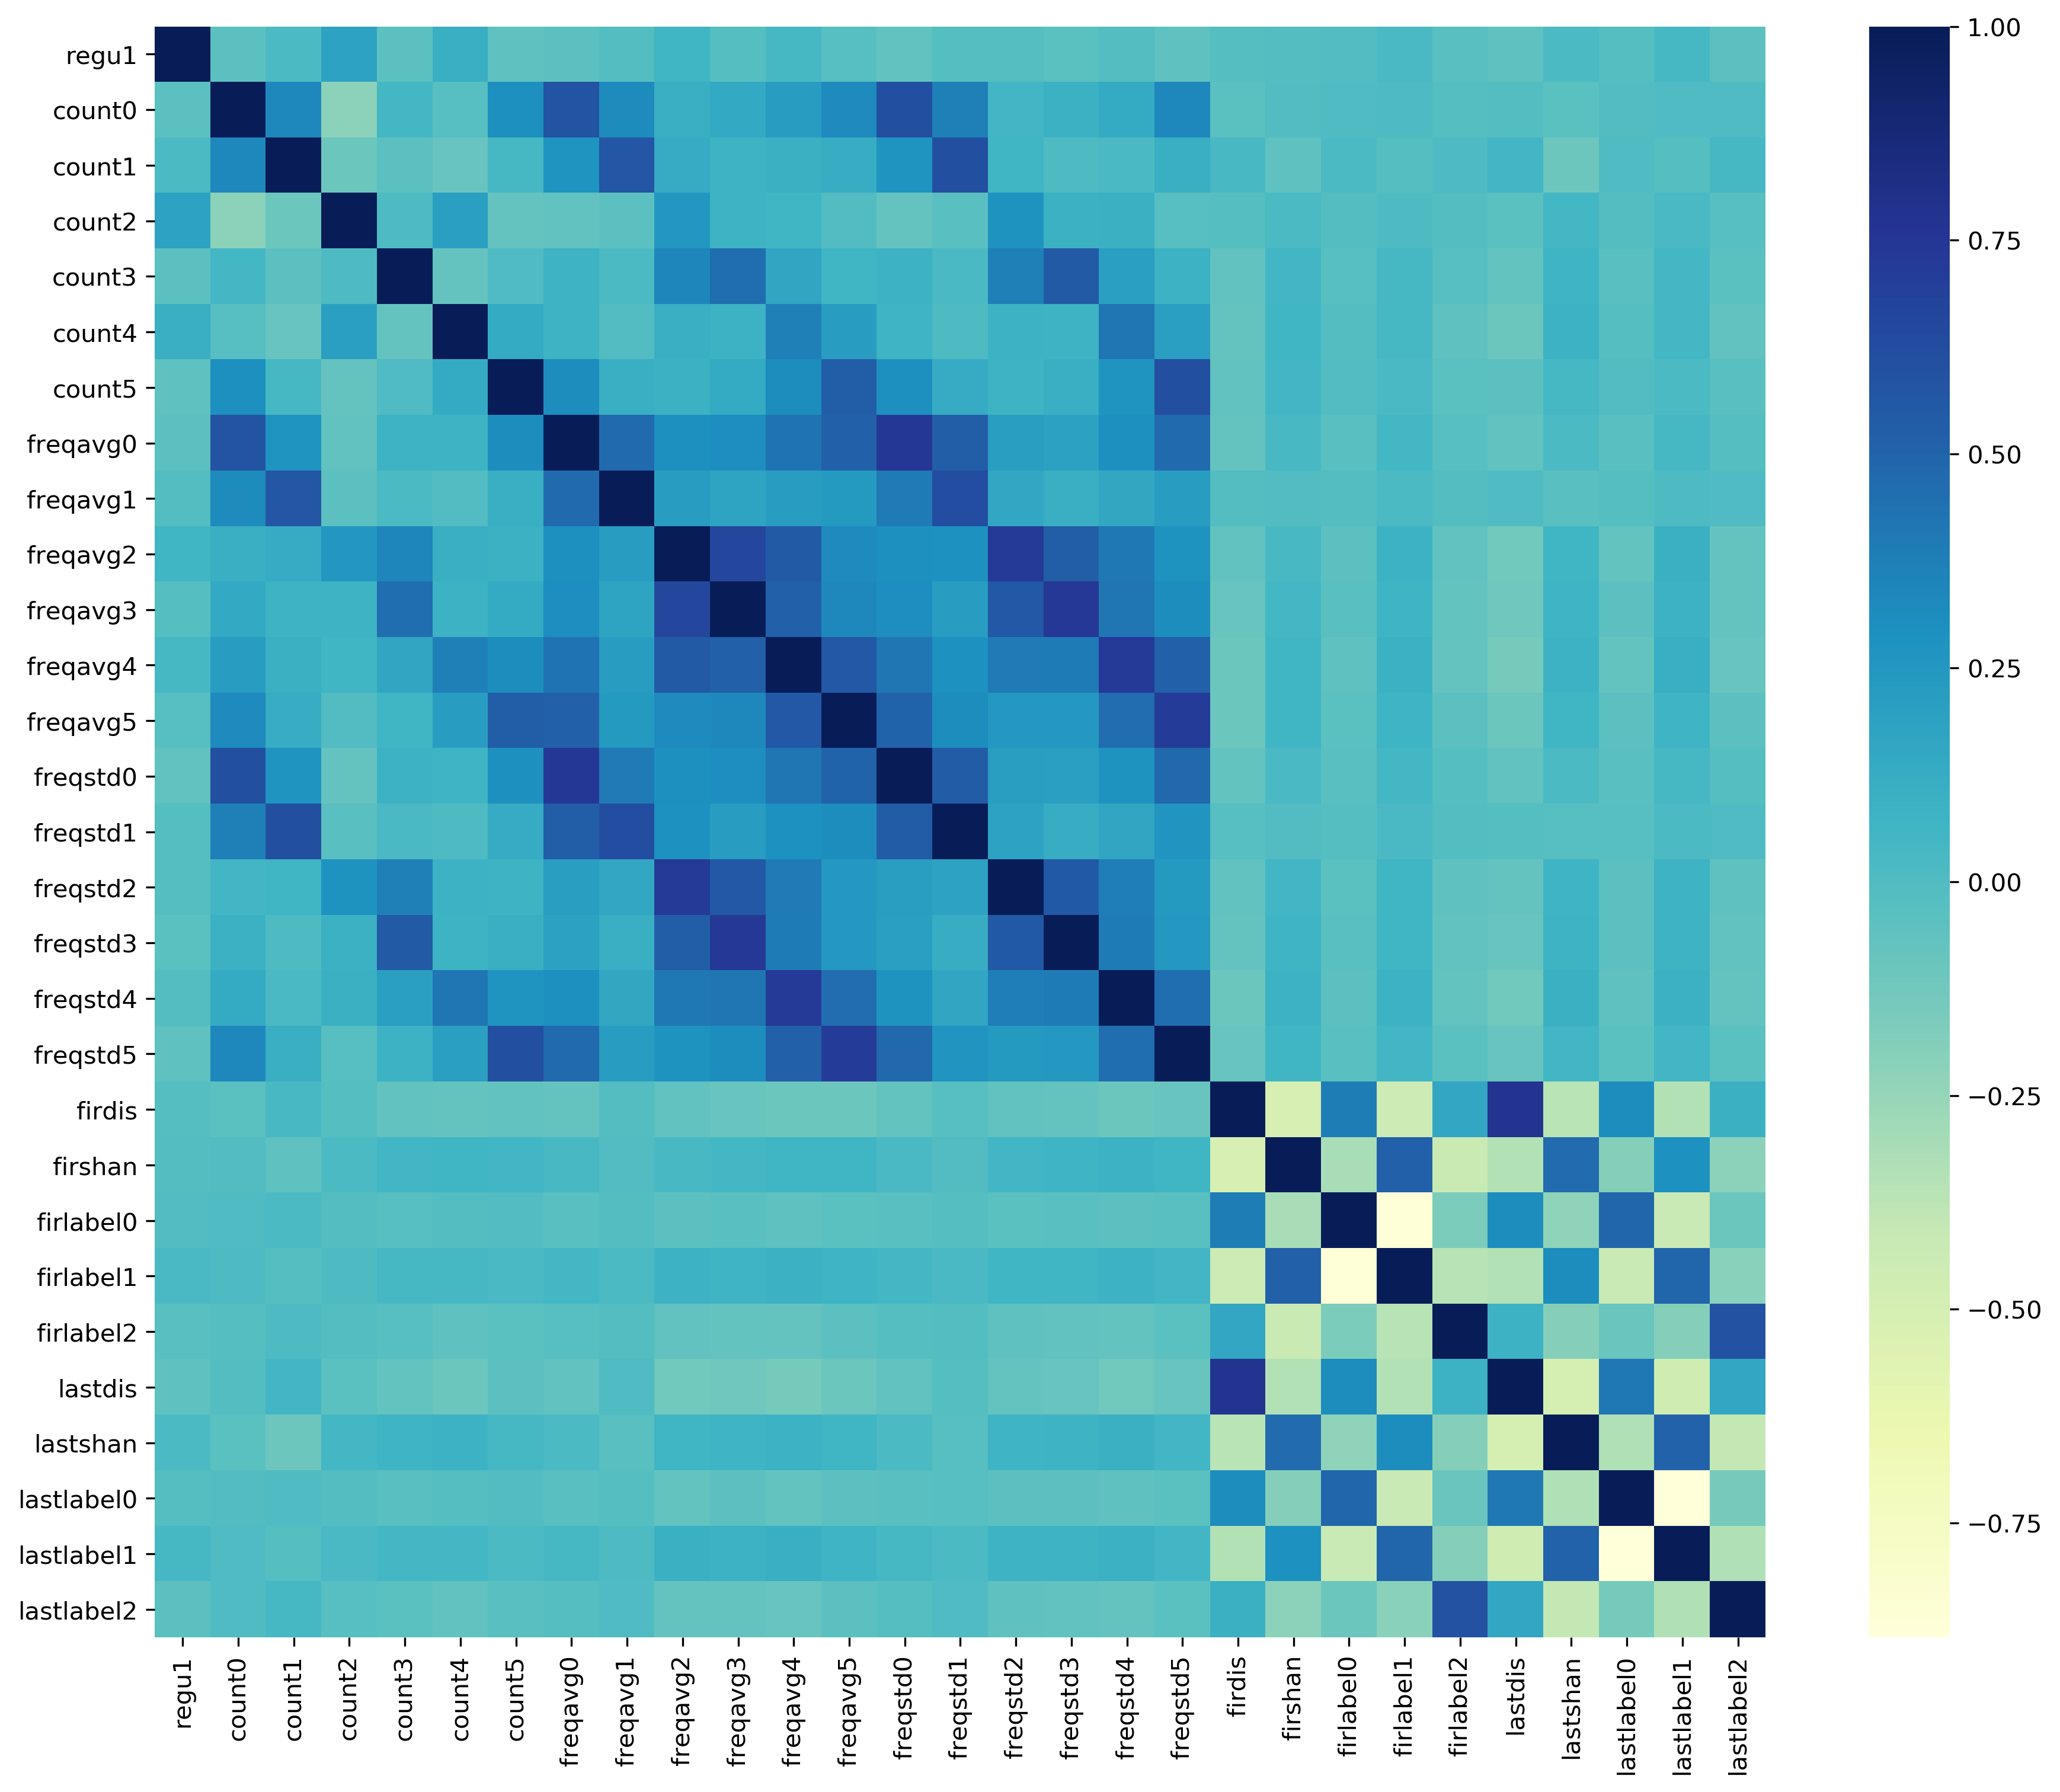

In [5]:
# 绘制各个变量的相关性热力图
plt.rcParams['figure.dpi'] = 300 #分辨率
plt.subplots(figsize=(15, 12))
sns.heatmap(AllStaPat[['regu1','count0','count1','count2','count3','count4','count5','freqavg0','freqavg1','freqavg2','freqavg3','freqavg4',
           'freqavg5','freqstd0','freqstd1','freqstd2','freqstd3','freqstd4','freqstd5','firdis','firshan','firlabel0','firlabel1',
           'firlabel2','lastdis','lastshan','lastlabel0','lastlabel1','lastlabel2']].corr(),
           annot=False, vmax=1, square=True,cmap="YlGnBu")

In [6]:
# 查看下存在NULL的行
tmp = AllStaPat[['regu1','count0','count1','count2','count3','count4','count5','freqavg0','freqavg1','freqavg2','freqavg3','freqavg4',
           'freqavg5','freqstd0','freqstd1','freqstd2','freqstd3','freqstd4','freqstd5','firdis','firshan','firlabel0','firlabel1',
           'firlabel2','lastdis','lastshan','lastlabel0','lastlabel1','lastlabel2','label']]
tmp[tmp.isnull().T.any()]

,regu1,count0,count1,count2,count3,count4,count5,freqavg0,freqavg1,freqavg2,...,firshan,firlabel0,firlabel1,firlabel2,lastdis,lastshan,lastlabel0,lastlabel1,lastlabel2,label


In [7]:
# 离群值检测及处理
# 使用马氏距离进行离群值检测
# 将自变量转化为numpy.array
indepvar = AllStaPat[['regu1','count0','count1','count2','count3','count4','count5','freqavg0','freqavg1','freqavg2','freqavg3','freqavg4',
           'freqavg5','freqstd0','freqstd1','freqstd2','freqstd3','freqstd4','freqstd5','firdis','firshan','firlabel0','firlabel1',
           'firlabel2','lastdis','lastshan','lastlabel0','lastlabel1','lastlabel2','label']]
indepvar = indepvar.dropna()
indepvar = indepvar.to_numpy()
indepvar

array([[0.38725424, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.44163973, 0.        , 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.54791821, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.5241342 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.28205175, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.61128748, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ]])

In [8]:
print("存在NULL的行共有{0}行，删除NULL值后还存在{1}行数据.".format((len(AllStaPat) - len(indepvar)) , len(indepvar)))

存在NULL的行共有0行，删除NULL值后还存在245743行数据.


In [9]:
# Covariance matrix
covariance  = np.cov(indepvar[:,:-1] , rowvar=False)

# Covariance matrix power of -1
covariance_pm1 = np.linalg.matrix_power(covariance, -1)  #对协方差矩阵取逆

# Center point
centerpoint = np.mean(indepvar[:,:-1] , axis=0)

# Distances between center point and other points
distances = []
for i, val in enumerate(indepvar[:,:-1]):
    if i % 100000 == 0:
        print("已经处理到第{0}行.".format(i))
    p1 = val
    p2 = centerpoint
    distance = (p1-p2).T.dot(covariance_pm1).dot(p1-p2)
    distances.append(distance)
distances = np.array(distances)

# Cutoff (threshold) value from Chi-Sqaure Distribution for detecting outliers 
cutoff = chi2.ppf(0.95, indepvar[:,:-1].shape[1])

# Index of outliers
outlierIndexes = np.where(distances > cutoff )

print('--- Index of Outliers ----')
print("离群值共有{0}个数据点,占比为{1}%.".format(len(outlierIndexes[0]) , round(len(outlierIndexes[0]) / len(indepvar)*100 , 2) ))
print(outlierIndexes)
# array([24, 35, 67, 81])

print('--- Observations found as outlier -----')
print(indepvar[ distances > cutoff , :])

已经处理到第0行.
已经处理到第100000行.
已经处理到第200000行.
--- Index of Outliers ----
离群值共有33381个数据点,占比为13.58%.
(array([    10,     14,     15, ..., 245735, 245736, 245742]),)
--- Observations found as outlier -----
[[0.746      1.         1.         ... 1.         0.         1.        ]
 [0.55355156 9.         2.         ... 1.         0.         1.        ]
 [0.68957688 8.         0.         ... 1.         0.         2.        ]
 ...
 [0.42882428 0.         0.         ... 0.         1.         0.        ]
 [0.63580952 0.         5.         ... 0.         1.         1.        ]
 [0.61128748 0.         0.         ... 0.         1.         0.        ]]


In [10]:
# 将上述的离群值删除
indepvar = indepvar[ distances <= cutoff , :]
len(indepvar)

212362

In [11]:
from collections import Counter
y_true = indepvar[:,-1]
# 查看去除离群值后各个类别的样本数量
print(Counter(y_true))

Counter({0.0: 102452, 1.0: 90038, 2.0: 19872})


In [12]:
# 将马氏距离过滤后的数据进行归一化处理
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
indepvar_minmax = min_max_scaler.fit_transform(indepvar[:,:-1])
indepvar_minmax

array([[0.27173702, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.33637548, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.46268999, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       ...,
       [0.53025008, 0.125     , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.43442212, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.14670135, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ]])

In [13]:
from collections import Counter
# 查看样本类别分布，0和1样本比例3.24比1，属于类别不平衡数据
print(Counter(y_true))

Counter({0.0: 102452, 1.0: 90038, 2.0: 19872})


In [14]:
# 目前数据存在严重的样本不均衡问题，因此采用过采样（SMOTE）的手段，使得样本的各个label的数据量相当,然后做特征选择
# 使用imlbearn库中上采样方法中的SMOTE接口
from imblearn.over_sampling import BorderlineSMOTE
# 定义SMOTE模型，random_state相当于随机数种子的作用
smo = BorderlineSMOTE(random_state=0)
indepvar_minmax_smo, y_smo = smo.fit_resample(indepvar_minmax , y_true)
print(Counter(y_smo))

Counter({0.0: 102452, 1.0: 102452, 2.0: 102452})


RFECV链接：https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV

In [15]:
# 使用RFECV得到最优的特征数量
# Feature ranking with recursive feature elimination and cross-validated selection of the best number of features.
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree

# estimator = LogisticRegression(penalty='none' ,random_state=0 ,class_weight='balanced',solver='sag')
# estimator = RandomForestClassifier(n_estimators=100 , max_depth= 6 , random_state = 1 , class_weight = 'balanced')
estimator = tree.DecisionTreeClassifier(max_depth = 50 , random_state=0,class_weight = 'balanced')
selector = RFECV(estimator, step=1, cv=5 ,scoring='accuracy')
selector = selector.fit(indepvar_minmax_smo , y_smo)
print(selector.support_)
print(selector.ranking_)

[ True False False  True  True  True  True  True False  True  True  True
  True False False  True  True  True  True  True  True False False False
  True  True False False False]
[ 1  2  7  1  1  1  1  1  4  1  1  1  1  9 12  1  1  1  1  1  1  3  6 10
  1  1  5  8 11]


In [16]:
# 观察最优模型的得分
# The cross-validation scores such that grid_scores_[i] corresponds to the CV score of the i-th subset of features.
selector.grid_scores_

array([0.43616542, 0.32690806, 0.35565961, 0.39613698, 0.40026244,
       0.43017879, 0.47338942, 0.49486292, 0.52336739, 0.53236019,
       0.53522008, 0.53761144, 0.54144738, 0.55453648, 0.5581707 ,
       0.56014887, 0.5606662 , 0.56268014, 0.56129412, 0.56167479,
       0.56153489, 0.56150235, 0.56184399, 0.56212379, 0.56232226,
       0.5622279 , 0.56241987, 0.56255326, 0.56236455])

In [17]:
selectfeat = []  #筛选出来的特征的index
for i in range(len(selector.ranking_)):
    if selector.ranking_[i] == 1:
        selectfeat.append(i)
selectfeat

[0, 3, 4, 5, 6, 7, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 24, 25]

## 9.7用筛选出的特征拟合随机森林模型观察效果

这一部分仅仅是为了观察一下效果，并不作为分析内容放到论文里的，这一部分对应的分析已经放到本地跑了，详见本地文件夹“筛选出的特征进行随机森林模型拟合”。

In [18]:
# 得到特征筛选后的数据集
indepvar_filt = indepvar[:,:-1][: , selectfeat ]
indepvar_filt.shape

(212362, 18)

In [19]:
# 将数据划分为训练集及测试集
from sklearn.model_selection import train_test_split
# x为数据集的feature，y为label.
x_train, x_test, y_train, y_test = train_test_split(indepvar_filt , y_true, test_size = 0.3 ,random_state=0)
x_train

array([[ 0.576     ,  5.        , 10.        , ...,  0.98246006,
         6.918     ,  0.98437873],
       [ 0.53820702, 10.        , 10.        , ...,  0.9701406 ,
        12.663     ,  0.9925649 ],
       [ 0.75733333, 10.        ,  4.        , ...,  0.95956639,
         3.084     ,  0.96642487],
       ...,
       [ 0.8537037 ,  7.        ,  1.        , ...,  0.80922886,
         2.033     ,  0.96621008],
       [ 0.66319866, 10.        , 10.        , ...,  0.9883014 ,
         2.771     ,  0.99566563],
       [ 0.70177778,  4.        ,  8.        , ...,  0.97377962,
         5.219     ,  0.98162391]])

In [20]:
# 对数据做归一化处理
min_max_scaler = preprocessing.MinMaxScaler()
x_train_minmax = min_max_scaler.fit_transform(x_train)
x_test_minmax = min_max_scaler.transform(x_test)
x_test_minmax

array([[0.34229351, 0.7       , 0.9       , ..., 0.86653259, 0.12878647,
        0.91588314],
       [0.54581795, 1.        , 0.3       , ..., 0.86092025, 0.35328006,
        0.86040006],
       [0.35256541, 0.3       , 0.8       , ..., 0.95459392, 0.02722542,
        0.95285451],
       ...,
       [0.55666233, 1.        , 0.1       , ..., 0.90699656, 0.45567738,
        0.83798993],
       [0.81429314, 0.8       , 0.1       , ..., 0.9674519 , 0.12762498,
        0.98780394],
       [0.52352926, 0.7       , 0.8       , ..., 0.72793433, 0.34937744,
        0.73750562]])

In [21]:
# 目前数据存在严重的样本不均衡问题，因此采用过采样（SMOTE）的手段，使得样本的各个label的数据量相当,然后做特征选择
# 定义SMOTE模型，random_state相当于随机数种子的作用
print(Counter(y_train))
smo = BorderlineSMOTE(random_state=0)
x_train_minmax_smo, y_train_smo = smo.fit_resample(x_train_minmax , y_train)
print(Counter(y_train_smo))

Counter({0.0: 71770, 1.0: 63051, 2.0: 13832})
Counter({0.0: 71770, 1.0: 71770, 2.0: 71770})


[[20316  5299  5067]
 [10867  7843  8277]
 [ 2038  1317  2685]]


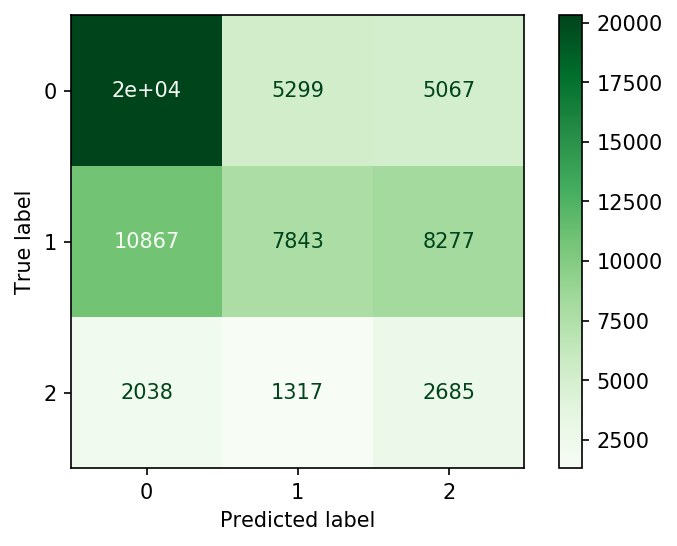

<Figure size 900x600 with 0 Axes>

In [22]:
# 训练随机森林模型，并观察随机森林模型效果
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# clf = LogisticRegression(penalty='none' ,random_state=0 ,class_weight='balanced',solver='sag')
clf = RandomForestClassifier(n_estimators=500 , max_depth= 6 , random_state = 1 , class_weight = 'balanced')
# clf = GradientBoostingClassifier(n_estimators=100 ,learning_rate=0.1 , max_depth = 12 , random_state = 1)
clf.fit(x_train_minmax_smo ,y_train_smo)
y_pred = clf.predict(x_test_minmax)
# 绘制混淆矩阵
cm = confusion_matrix(y_test , y_pred)
print(cm)
plt.rcParams['figure.dpi'] = 150
cm_display = ConfusionMatrixDisplay(cm, display_labels = ['0', '1', '2'])
print(cm_display)
cm_display.plot(cmap = 'Greens')
plt.show()
plt.clf()

In [23]:
# 计算accurancy，macre-precision，macro-recall
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('accurancy:' ,accuracy_score(y_test, y_pred , normalize=True))
print('macre-precision:' ,precision_score(y_test, y_pred , average='macro')) # precision
print('macro-recall:' , recall_score(y_test, y_pred , average='macro'))  # recall
print('macro-f1-score:' , f1_score(y_test, y_pred , average='macro'))  # f1-score

accurancy: 0.4841388186912367
macre-precision: 0.44049336772039177
macro-recall: 0.465768340475218
macro-f1-score: 0.4192116020996577


In [24]:
feat_list = ['regu1','count0','count1','count2','count3','count4','count5','freqavg0','freqavg1','freqavg2','freqavg3','freqavg4',
           'freqavg5','freqstd0','freqstd1','freqstd2','freqstd3','freqstd4','freqstd5','firdis','firshan','firlabel0','firlabel1',
           'firlabel2','lastdis','lastshan','lastlabel0','lastlabel1','lastlabel2']
feat_name_list = []
for i in range(len(selectfeat)):
    feat_name_list.append(feat_list[selectfeat[i]])
feat_name_list

['regu1',
 'count2',
 'count3',
 'count4',
 'count5',
 'freqavg0',
 'freqavg2',
 'freqavg3',
 'freqavg4',
 'freqavg5',
 'freqstd2',
 'freqstd3',
 'freqstd4',
 'freqstd5',
 'firdis',
 'firshan',
 'lastdis',
 'lastshan']

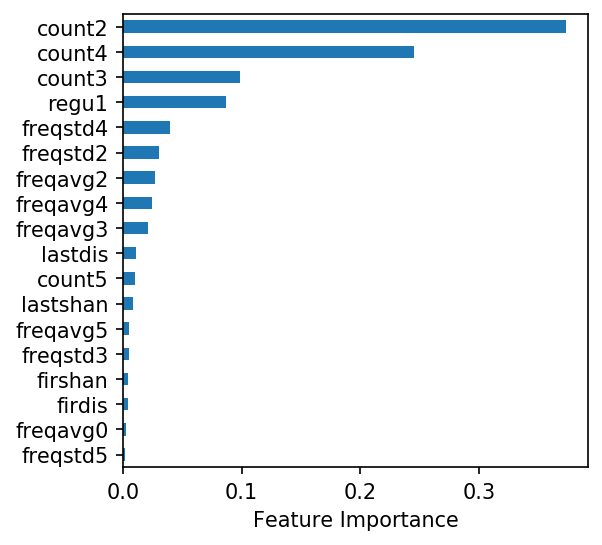

In [25]:
# 特征重要性排序
plt.figure(figsize=(4,4))
plt.rcParams['figure.dpi'] = 150
importance = list(clf.feature_importances_)
Impt_Series = pd.Series(importance, index = feat_name_list)
Impt_Series.sort_values(ascending = True).plot(kind='barh')
plt.xlabel("Feature Importance")
plt.show()

In [26]:
# 将特征重要性保存到本地去，在本地绘图
tmp = pd.DataFrame(list(clf.feature_importances_), columns=['feature importance'])
tmp['name'] = feat_name_list
tmp.to_excel("特征重要性排序.xlsx",encoding='gbk',index=False)

In [32]:
# 将最重要的4个特征在各个簇的均值求取出来
print(AllStaPat[AllStaPat['label']==0][['count2','count4','count3','regu1','label']].describe())
print(AllStaPat[AllStaPat['label']==1][['count2','count4','count3','regu1','label']].describe())
print(AllStaPat[AllStaPat['label']==2][['count2','count4','count3','regu1','label']].describe())

              count2         count4         count3          regu1     label
count  119666.000000  119666.000000  119666.000000  119666.000000  119666.0
mean        7.584301       5.936983       5.883024       0.623419       0.0
std         2.822121       3.062968       3.308084       0.163979       0.0
min         0.000000       0.000000       0.000000       0.158620       0.0
25%         6.000000       4.000000       3.000000       0.519225       0.0
50%         9.000000       7.000000       7.000000       0.631994       0.0
75%        10.000000       8.000000       9.000000       0.740625       0.0
max        10.000000      10.000000      10.000000       1.000000       0.0
              count2         count4         count3          regu1     label
count  103133.000000  103133.000000  103133.000000  103133.000000  103133.0
mean        8.601515       6.821299       6.234105       0.683062       1.0
std         2.342358       3.010999       3.404044       0.137242       0.0
min         

## 9.8 筛选出的特征的相关性分析

In [27]:
# 拼接自变量和因变量
tmp = pd.DataFrame(data=indepvar_filt , columns=feat_name_list)
tmp['label']=y_true
tmp.head(2)

,regu1,count2,count3,count4,count5,freqavg0,freqavg2,freqavg3,freqavg4,freqavg5,freqstd2,freqstd3,freqstd4,freqstd5,firdis,firshan,lastdis,lastshan,label
0,0.387254,6.0,3.0,7.0,1.0,0.0,1.666667,2.333333,1.428571,1.0,0.745356,1.247219,0.494872,0.0,13.378,0.950116,13.774,0.971018,0.0
1,0.441640,9.0,7.0,1.0,0.0,0.0,4.111111,5.285714,5.000000,0.0,4.067334,5.897076,0.000000,0.0,13.378,0.950116,13.774,0.971018,1.0


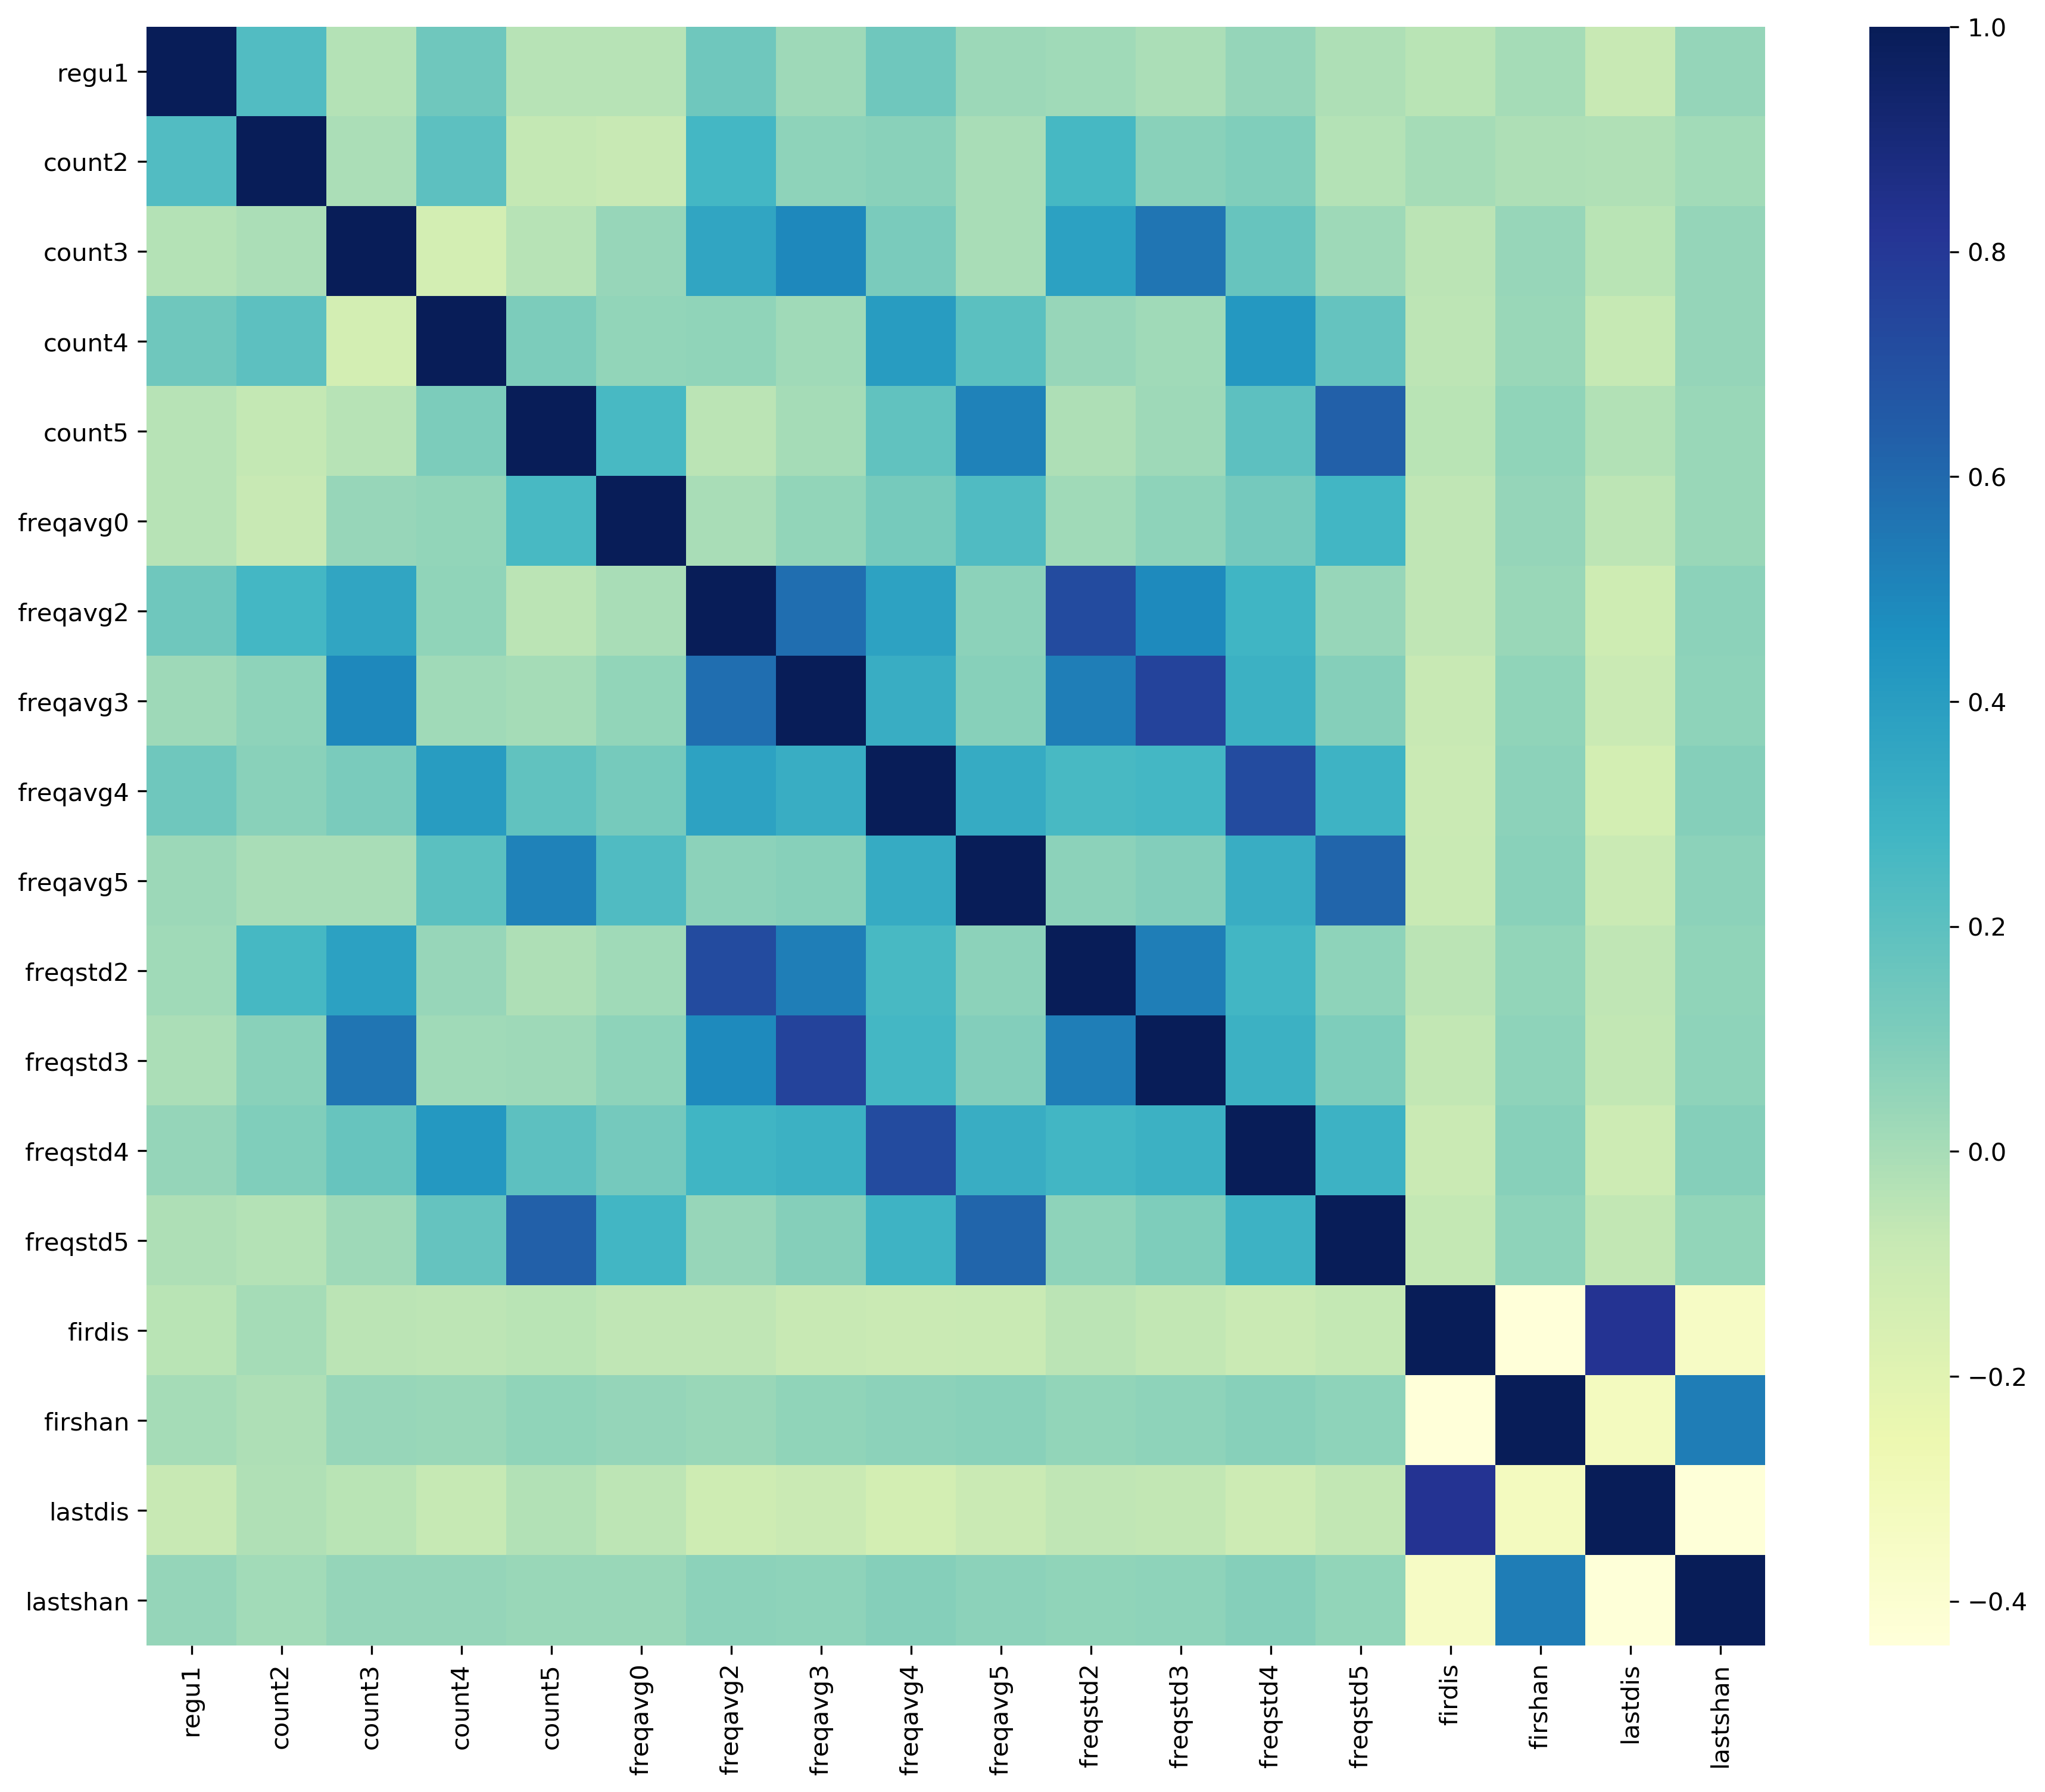

In [28]:
# 绘制各个变量的相关性热力图
plt.rcParams['figure.dpi'] = 300 #分辨率
plt.subplots(figsize=(15, 12))
sns.heatmap(tmp.iloc[:,:-1].corr(),
           annot=False, vmax=1, square=True,cmap="YlGnBu")

In [29]:
# 保存自变量和因变量到本地
tmp.to_csv('回归自变量及因变量(经过特征筛选).csv',encoding='gbk')

In [30]:
# 关闭数据库数据库连接
conn.close()
print("conn closed!")

NameError: name 'conn' is not defined